## Script to 
1. Detect Hump and Rising shaped curves
2. Save drug, cl and ti map to see howq many outlier curves per dr/cl/ti
3. Save curve category of each pair (DW, DNW, Hump, Rising) as category matrix and heatmap
###### **NOTE:  this script used dose response files in the old format : cl,dr have dataset specific names, 1 row for 1 pair not 1 doasge

In [1]:
# no use of tissue info
# changed code so that it uses standard file format and GDSC1 with 4 dosage drugs

In [2]:
__author__ = 'Aanchal'

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns;  sns.set()
import pandas as pd
import FUNCTIONS as f

In [5]:
dataname="CCLE" #"GDSC1replicatesSummarized"#"CCLE" #"CCLE" #
rawFileDir="../data/data_2019_12_05/"

sample_col_name='cell line name'
drug_col_name ='drug name'
dosage_col_name='Dosage (uM)' 
response_col_name='Response'
                                 
dataset=pd.read_csv(rawFileDir+dataname+"_dose_response.csv")
dataset=dataset[[sample_col_name, drug_col_name, dosage_col_name, response_col_name]]

dataset_names=dataset[[sample_col_name, drug_col_name]].drop_duplicates()
dataset_names=dataset_names.reset_index(drop=True)

In [26]:
def plot_pair(clname,drname,sample,log2dosage,shapename,dataname ):  
    fs=18
    plt.figure()
    plt.title(clname+" : "+drname+"\n"+str(sample))
    plt.scatter(log2dosage,sample)
    plt.ylim(-100,50)
    plt.xlabel("log2(uM)", fontsize=fs)
    plt.ylabel("Cell viability", fontsize=fs)
    plt.axhline(y=0, color='k', linestyle='--')
    plt.savefig("../figures/Outlier_Curves/"+dataname+"_Shape_"+shapename+"/"+clname+ "-" +drname+".png" ,  bbox_inches='tight')
    plt.show()

In [7]:
cl_set=(list(sorted(set(dataset_names[sample_col_name] ) )))
dr_set=(list(sorted(set( dataset_names[drug_col_name]  ) )))

In [8]:

flag_1=[0]*len(dataset_names)
flag_2=[0]*len(dataset_names)
flag_3=[0]*len(dataset_names)
flag_4=[0]*len(dataset_names)

#category_matrix= np.zeros(shape=(len(cl_set),len(dr_set)))
category_df=pd.DataFrame(np.zeros(shape=(len(cl_set),len(dr_set))) ,index=cl_set, columns=dr_set)

drug_map=pd.DataFrame()
cl_map=pd.DataFrame()

drug_map['DRUG_NAME'] = dr_set
cl_map['CL_NAME'] = cl_set

drug_map['OUTLIER_COUNT'] = [0]*len(dr_set)
cl_map['OUTLIER_COUNT'] = [0]*len(cl_set)

drug_map['#cl_tested'] = [0]*len(dr_set)
cl_map['#dr_tested'] = [0]*len(cl_set)

In [9]:
response_range=200#np.nanpercentile(t.values[:,0], 99.99) - np.nanpercentile(t.values[:,-1], 0.01)

###### commented out assigning DW and DNW category  bcz we just want to show outliers (Hump/rising) in heatmap (0:Not tested,1: Tetsed, 3:hump, 4:rising)

In [10]:
len(dataset_names)

11670

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

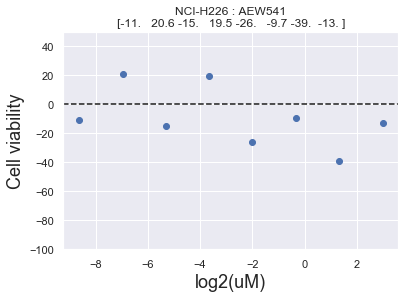

326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575


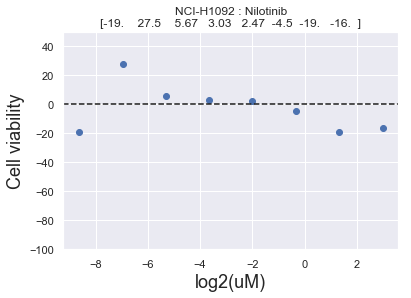

744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886


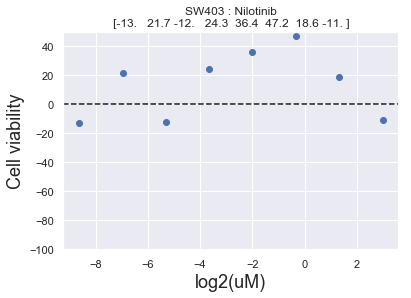

887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
110

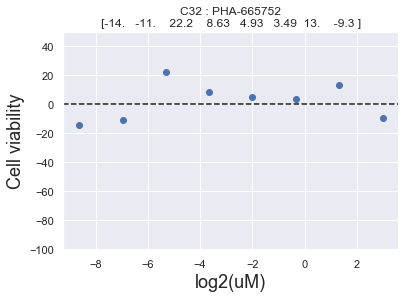

1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
HS739T PHA-665752


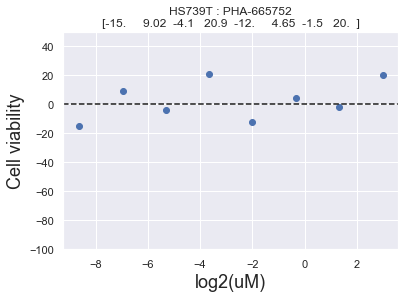

1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
JM1 PHA-665752


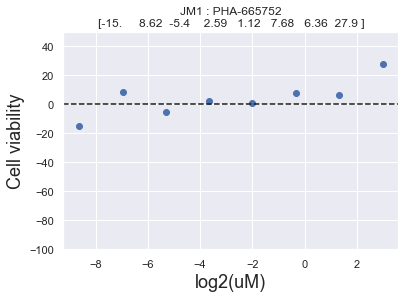

1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
OVCAR-3 PHA-665752


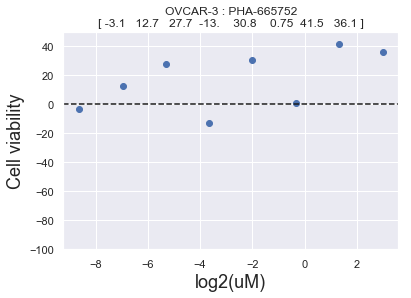

1773
1774
1775
1776
1777
1778
1779
1780
OCILY10 PHA-665752


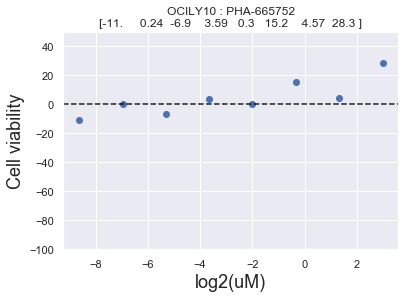

1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
PANC-03-27 PHA-665752


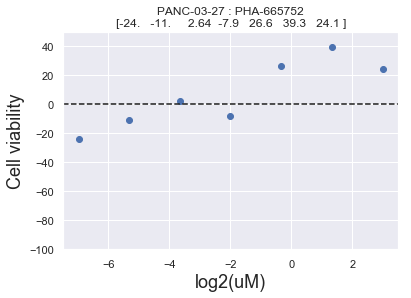

1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
SU-DHL-10 PHA-665752


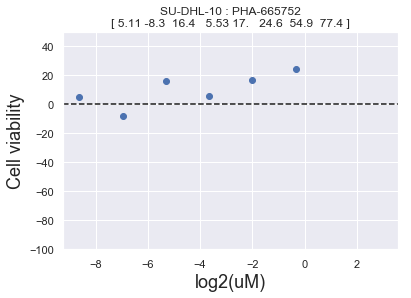

1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
TE-11 PHA-665752


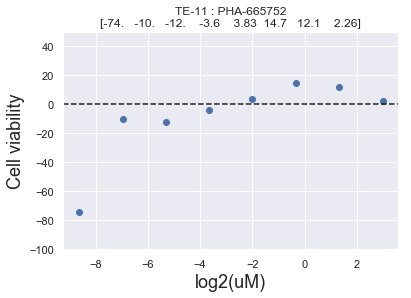

1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995


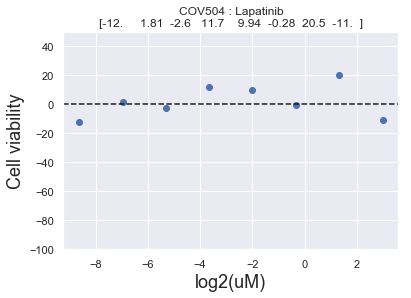

1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
GRANTA-519 Lapatinib


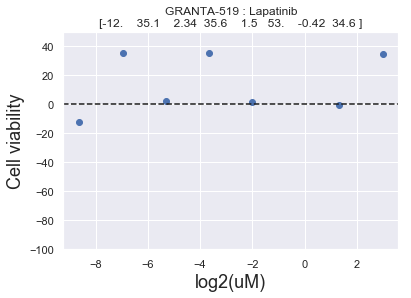

2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
HH Lapatinib


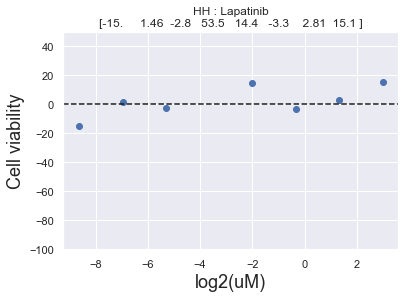

2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173


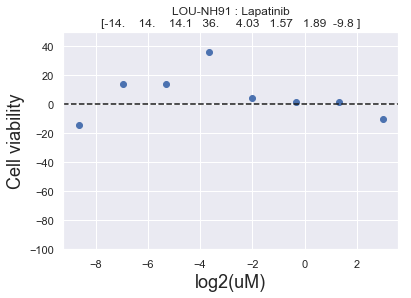

2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198


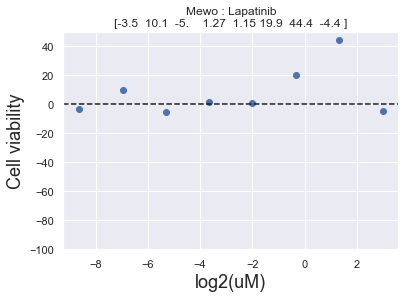

2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
NCI-H1184 Lapatinib


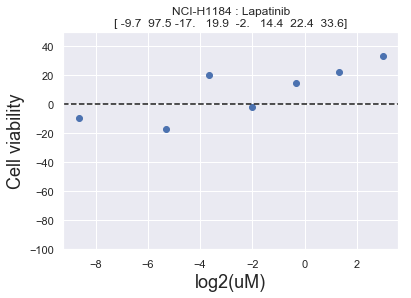

2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235


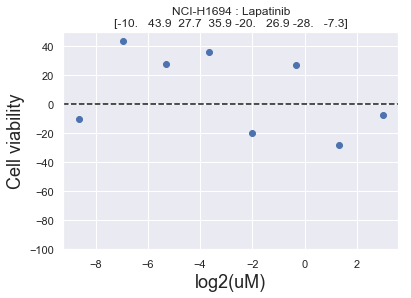

2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272


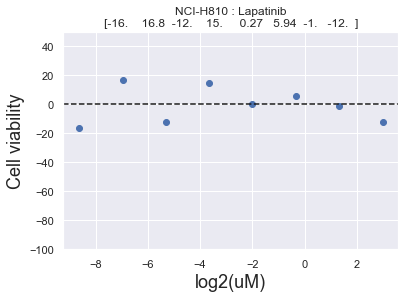

2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
OCILY10 Lapatinib


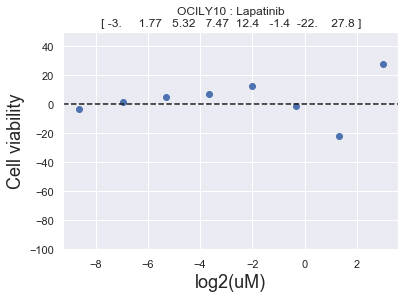

2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
SK-MEL-2 Lapatinib


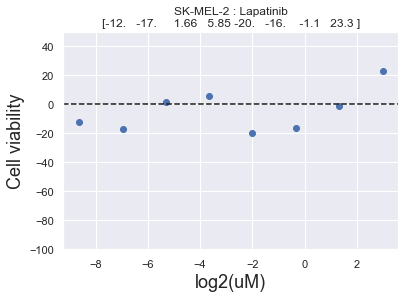

2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
TC-71 Lapatinib


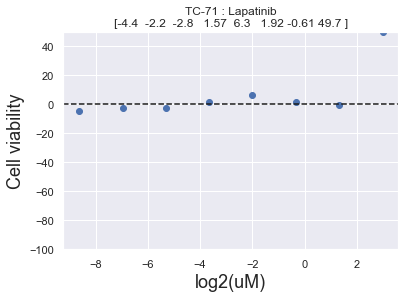

2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433


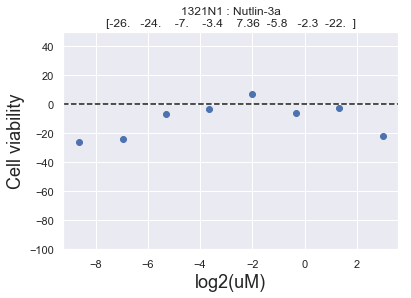

2434
2435
2436
2437
2438
2439
2440
2441
2442
2443


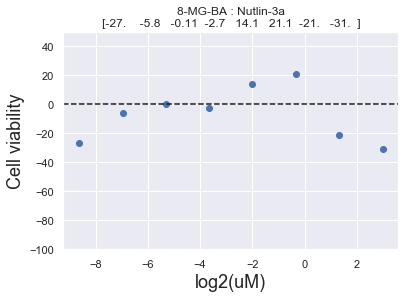

2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
AsPC-1 Nutlin-3a


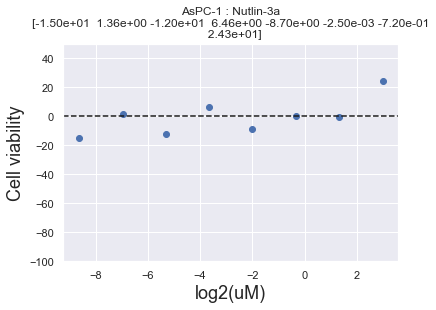

2457
2458
2459
2460


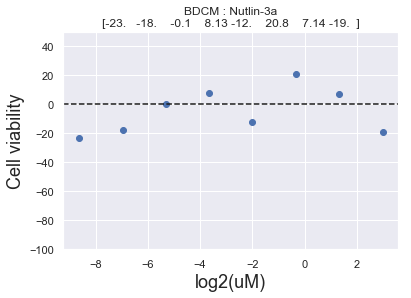

2461
2462
2463
2464
2465
2466
2467
2468
BxPC-3 Nutlin-3a


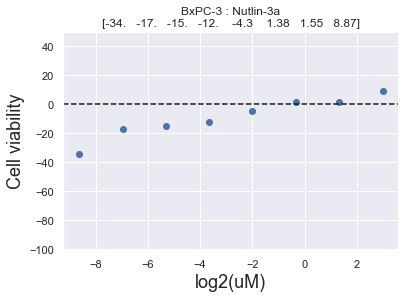

2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481


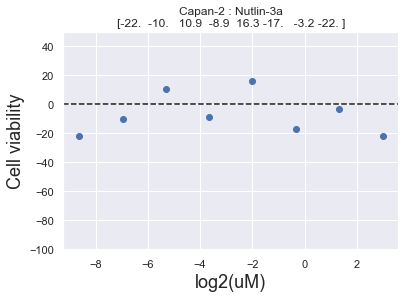

2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535


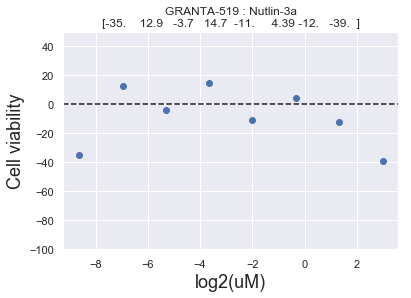

2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554


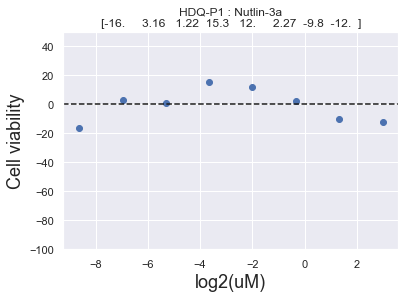

2555
2556
2557
2558
2559
2560
2561
2562
2563
HEP3B217 Nutlin-3a


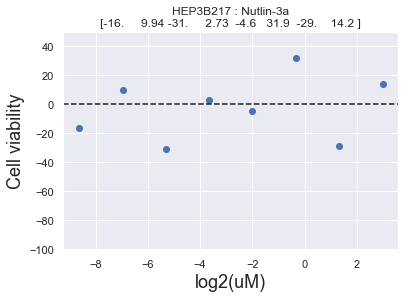

2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648
2649
KNS-62 Nutlin-3a


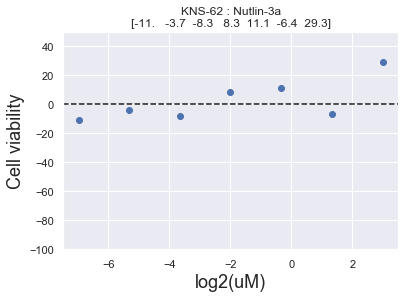

2650
2651
2652
2653
2654
2655
2656
2657
2658
2659
KURAMOCHI Nutlin-3a


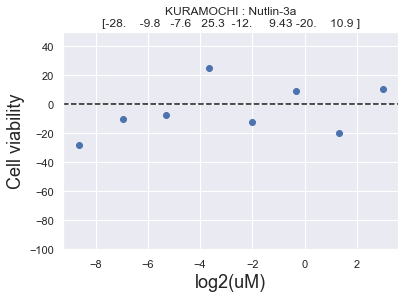

2660
2661
2662
2663
2664
2665
2666
2667
2668
2669
2670
2671
2672
2673
2674
2675
2676
2677
2678
2679
2680
2681
2682
2683
2684
2685
2686
2687
2688
2689
2690
2691
2692
2693
2694
2695
2696
2697
2698
2699
2700
2701
2702
2703
2704
2705
2706
2707
2708
2709
2710
2711
2712
MKN7 Nutlin-3a


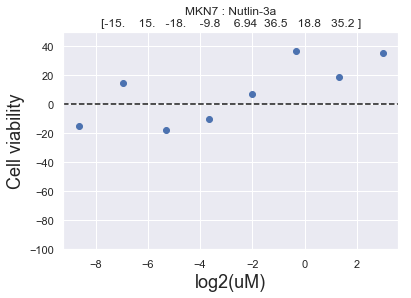

2713
2714
2715
2716
2717
2718
2719
2720
2721
2722
2723
2724
2725
2726
2727
2728
2729
2730
2731
2732
2733
2734
2735
2736
2737
2738
2739
NCI-H1694 Nutlin-3a


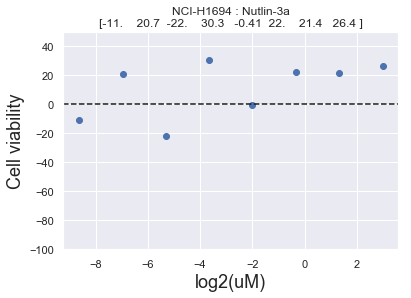

2740
2741
2742


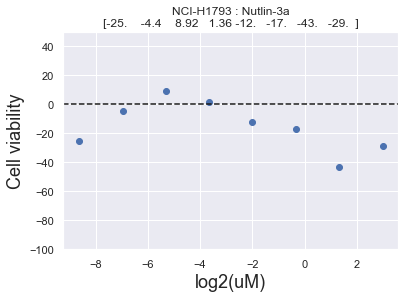

2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777
2778
2779
OVCAR-3 Nutlin-3a


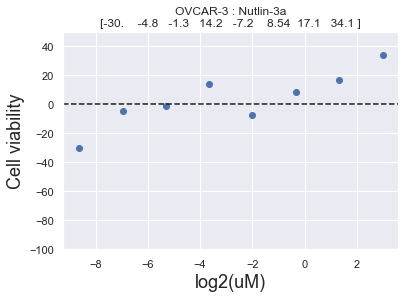

2780
NUGC-3 Nutlin-3a


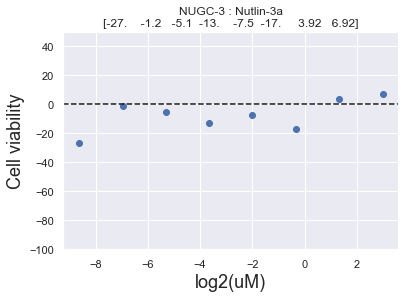

2781
2782
2783
2784
2785
2786
2787
OCILY10 Nutlin-3a


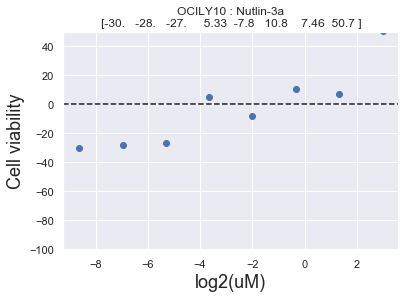

2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801
2802
2803
2804
2805
2806
PANC-10-05 Nutlin-3a


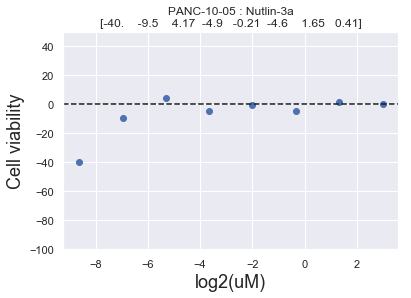

2807
2808
2809
2810
2811
2812
2813
2814
2815
2816
2817
2818
2819
2820
2821
2822
2823
2824
2825
2826
2827
2828
2829
2830
2831
2832
2833
2834
2835
2836
2837
2838
2839
2840
2841
2842
2843
2844
2845
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855
2856
2857
2858
2859
2860
2861
2862
SK-N-FI Nutlin-3a


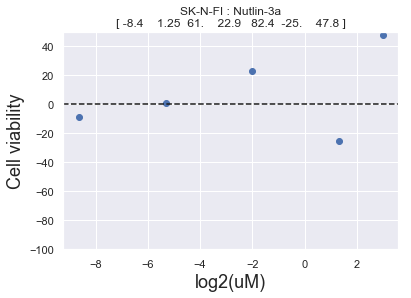

2863
2864
2865
2866
2867
2868
2869
2870
2871
2872
2873
2874
2875
2876
2877
2878
SU-DHL-10 Nutlin-3a


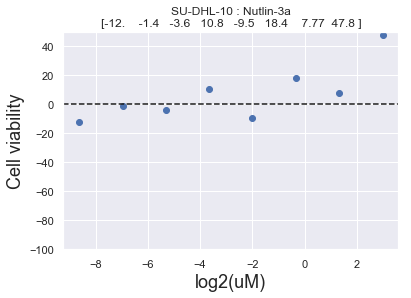

2879
2880
2881
2882
2883
2884
2885
2886
2887
2888
2889
2890
2891
SW403 Nutlin-3a


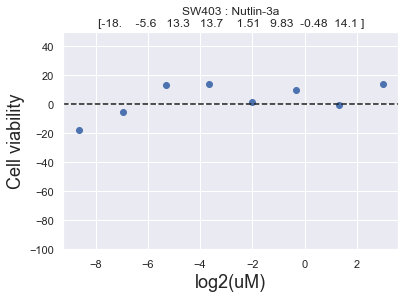

2892
2893
2894
2895
2896
2897
2898
2899
2900
2901


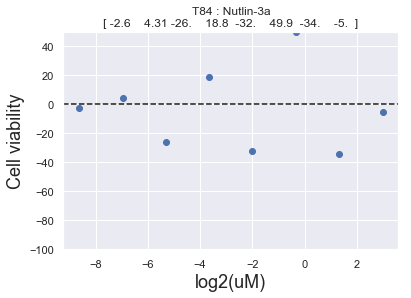

2902
2903
2904
2905
2906
TE-11 Nutlin-3a


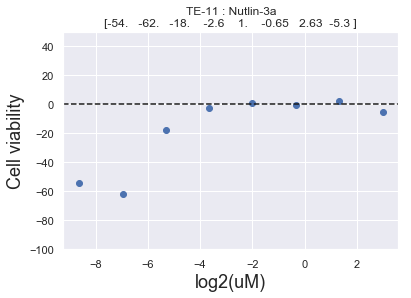

2907
2908
2909
2910
2911
2912
2913
2914
2915
2916
2917
2918
2919
2920
2921
2922
2923


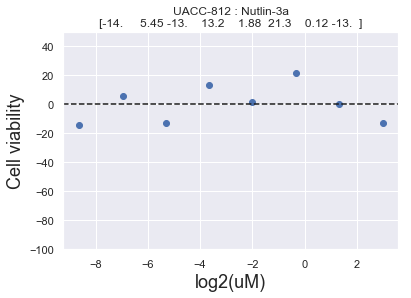

2924
2925
2926
2927
2928
2929
2930
2931
2932
2933
2934
2935
2936
2937
2938
2939
2940
2941
2942
2943
2944
2945
2946
2947
2948
2949
2950
2951
2952
2953
2954
2955
2956
2957
2958
2959
2960
2961
2962
2963
2964
2965
2966
2967
2968
2969
2970
2971
2972
2973
2974
2975
2976
2977
2978
2979
2980
2981
2982
2983
2984
2985
2986
2987
2988
2989
2990
2991
2992
2993
2994
2995
2996
2997
2998
2999
3000
3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015
3016
3017
3018
3019
3020
3021
3022
3023
3024
3025
3026
3027
3028
3029
3030
3031
3032
3033
3034
3035
3036
3037
3038
3039
3040
3041
3042
3043
3044
3045
3046
3047
3048
3049
3050
3051
3052
3053
HCC-78 Saracatinib


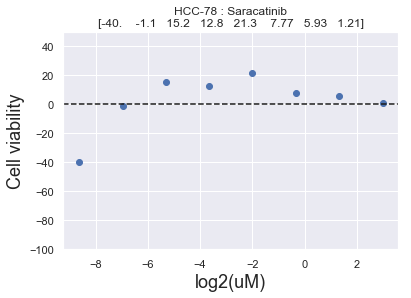

3054
3055
3056
3057
3058
3059
3060
3061
3062
3063
3064
3065
3066
HEL Saracatinib


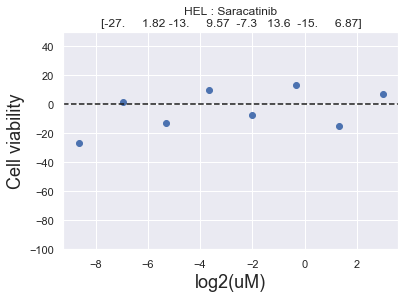

3067
3068
3069
3070
3071
3072
3073
3074
3075
3076
3077
3078
3079
3080
3081
3082
3083
3084
3085
3086
3087
3088
3089
3090
3091
3092
3093
3094
3095
3096
3097
3098
3099
3100
3101
3102
3103
3104
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
JM1 Saracatinib


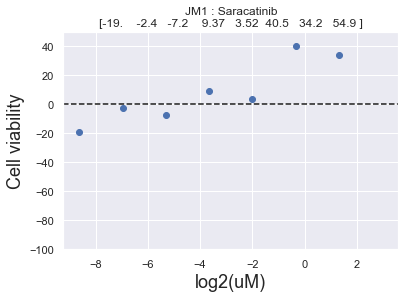

3126
3127
3128
3129
3130
3131
3132
3133
3134
3135
3136
3137
3138
3139
3140
3141
3142
3143
3144
3145
3146
3147
3148
3149
3150
3151
3152
3153
3154
3155
3156
3157
3158
3159
3160
3161
3162
3163
3164
3165
3166
3167
3168
3169
3170
3171
3172
3173
3174
3175
3176
3177
3178
3179
3180
3181
3182
3183
3184
3185
3186
3187
3188
3189
3190
3191
3192
3193
3194
3195
3196
3197
3198
3199
3200
3201
3202
3203
3204
3205
3206
3207
3208
3209
3210
3211
3212
3213
3214
3215
3216
3217
3218
3219
3220
3221
3222
3223
3224
3225
3226
3227
3228
NCI-H1184 Saracatinib


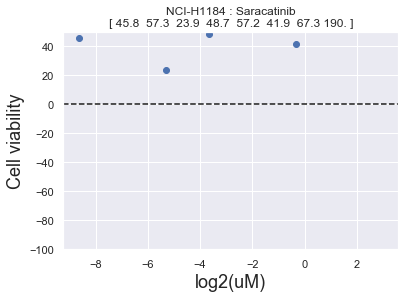

3229
3230
3231
3232
3233
3234
3235
3236
3237
NCI-H1581 Saracatinib


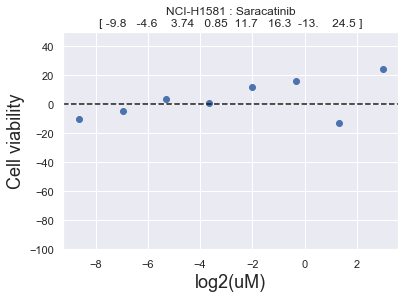

3238
3239
3240
3241
3242
3243
NCI-H1694 Saracatinib


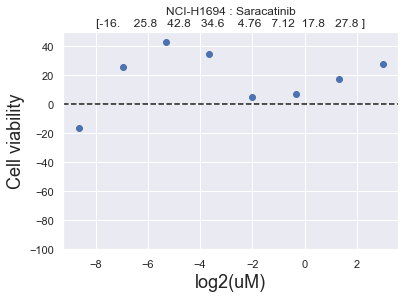

3244
3245
3246
3247
3248
3249
3250
3251
3252
3253
3254
3255
3256
3257
3258
3259
3260
3261
3262
3263
3264
3265
3266
3267
3268
3269
3270
3271
3272
3273
3274
3275
3276
3277
3278
3279
3280
3281
3282
3283
3284
3285
3286
3287
3288
3289
3290
3291
OCILY10 Saracatinib


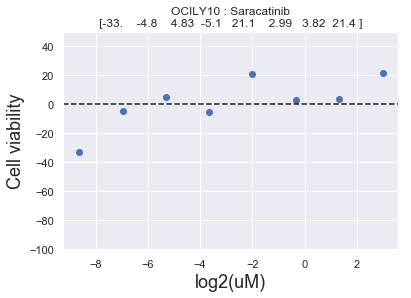

3292
3293
3294
3295
3296
3297
3298
3299
3300
3301
3302
3303
3304
3305
3306
3307
3308
3309
3310
3311
3312
3313
3314
3315
3316
3317
3318
3319
3320
3321
3322
3323
3324
3325
3326
3327
3328
3329
3330
3331
3332
3333
3334
3335
3336
3337
3338
3339
3340
3341
3342
3343
3344
3345
SHP-77 Saracatinib


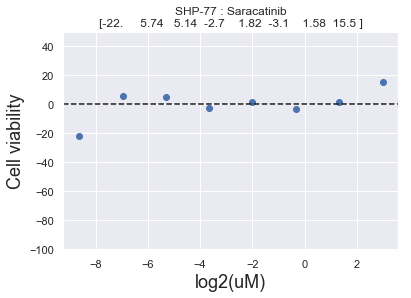

3346
3347
3348
3349
3350
3351
3352
3353
3354
3355
3356
3357
3358
3359
3360
3361
3362
3363
3364
3365
3366
SK-N-FI Saracatinib


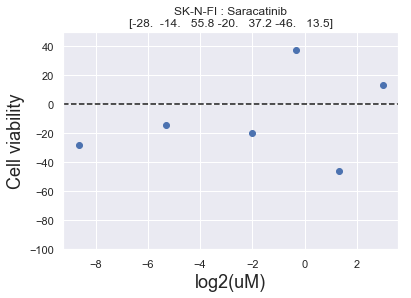

3367
3368
3369
3370
3371
3372
3373
3374
3375
3376
3377
3378
3379
3380
3381
3382
SU-DHL-10 Saracatinib


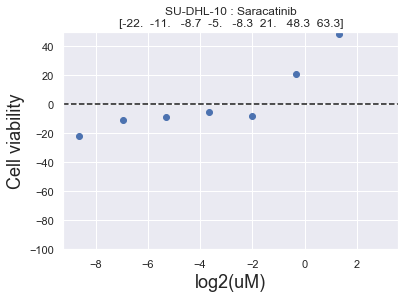

3383
3384
3385
3386
3387
3388
3389
3390
3391
3392
3393
3394
3395
3396
3397
3398
3399
3400
3401
3402
3403
3404
3405
3406
3407
3408
3409
3410
3411
3412
3413
3414
3415
3416
3417
3418
3419
3420
3421
3422
3423
3424
3425
3426
3427
3428
3429
3430
3431
3432
3433
3434
3435
3436
3437
3438
3439
3440
3441
3442
3443
3444
3445
3446
3447
3448
3449
3450
3451
3452
3453
3454
3455
3456
3457
3458
3459
3460
3461
3462
3463
3464
3465
3466
3467
3468
3469
3470
3471
3472
3473
3474
3475
3476


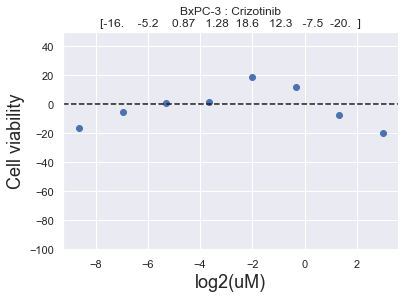

3477
3478
3479
3480
3481
3482
3483
3484
3485
3486
3487
3488
3489
3490
3491
3492
3493
3494
3495
3496
3497
3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
IA-LM Crizotinib


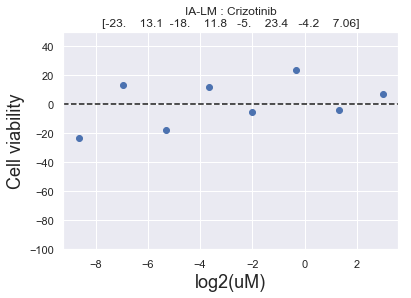

3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646


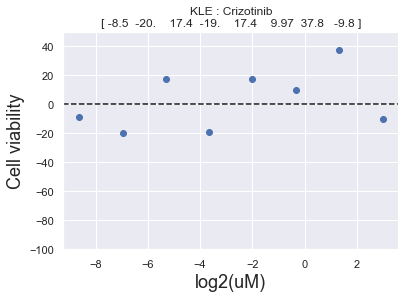

3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
KNS-62 Crizotinib


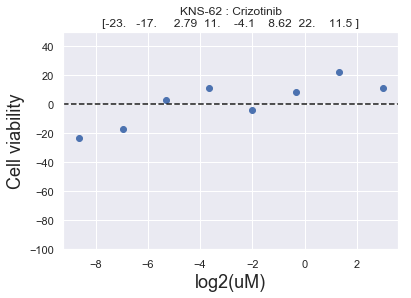

3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693


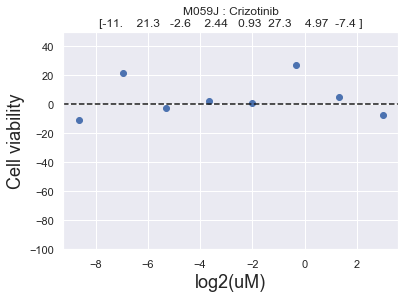

3694
3695
3696
3697
3698
3699
3700
3701


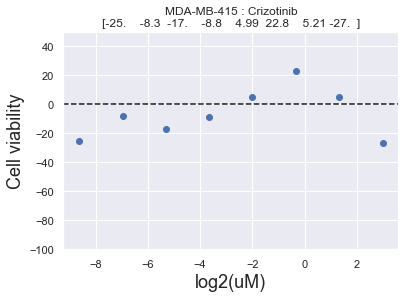

3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713


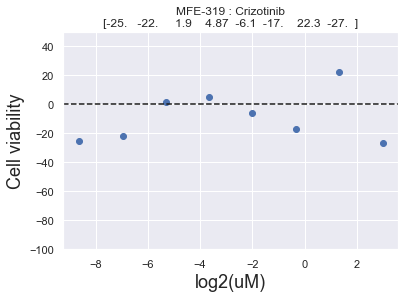

3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
NCI-N87 Crizotinib


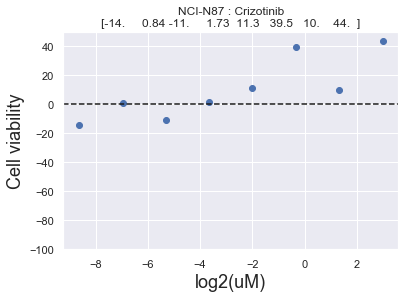

3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
OCILY10 Crizotinib


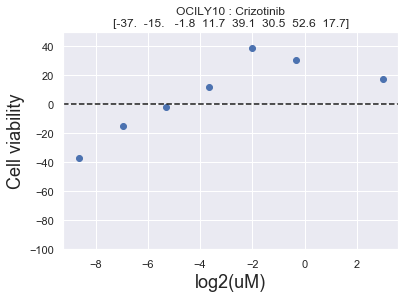

3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
SHP-77 Crizotinib


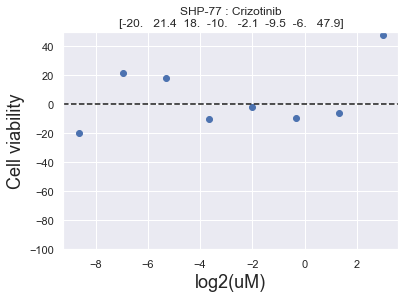

3850
3851
3852
3853
3854
SKBR3 Crizotinib


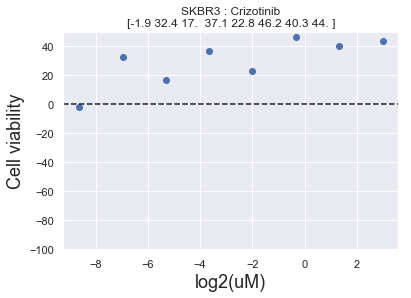

3855
3856
3857
3858
3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879
3880
3881
3882
3883
3884
3885
3886
3887
3888
3889
3890
3891
3892
3893
3894
3895
3896
3897
3898
3899
3900
3901
3902
3903
3904
3905
3906
3907
3908
3909
3910
3911
3912
3913
3914
3915
3916
3917
3918
3919


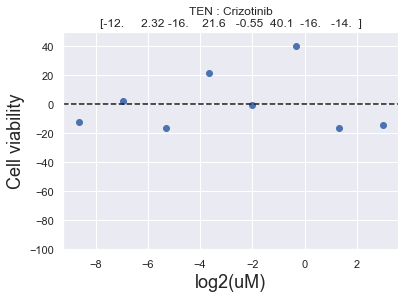

3920
3921
3922
3923
3924
3925
3926
3927
3928
3929
3930
3931
3932
3933
3934
3935
3936
3937
3938
3939
3940
3941
3942
3943
3944
3945
3946
3947
3948
3949
3950
3951
3952
3953
3954
3955
3956
3957
3958
3959
3960
3961
3962
3963
3964
3965
3966
3967
3968
3969
3970
3971
3972


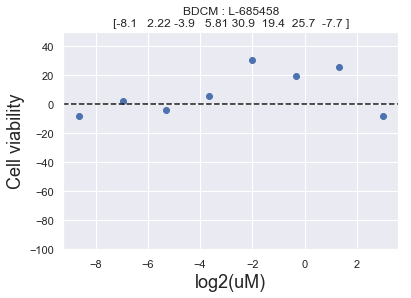

3973
3974
3975
3976
3977
3978
3979
3980
3981
3982
3983
3984
3985
3986
3987
3988
3989


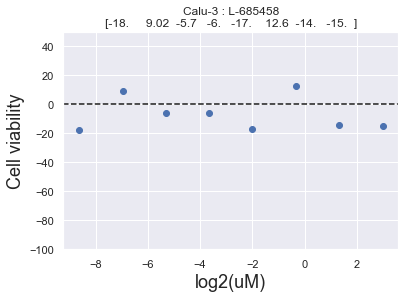

3990
3991
3992
3993
3994
3995
3996
3997
3998
3999
4000
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
HPAC L-685458


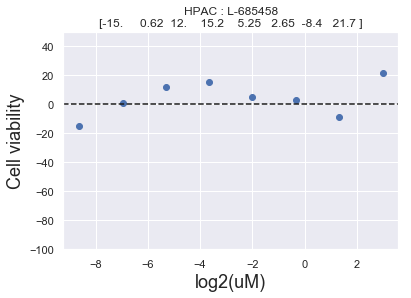

4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144


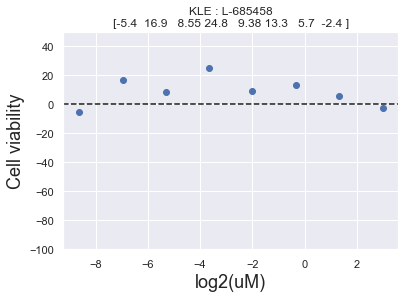

4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221
4222
4223
4224
4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236
4237
4238
4239
4240
4241
4242
4243
4244
4245
4246
4247
4248
4249
4250
4251
4252
4253
4254
4255
4256
4257
4258
4259
4260
4261
4262
4263
4264
4265
4266
4267
4268
4269
4270
4271
4272
4273
4274
4275
4276
4277
4278
4279
4280
4281
4282
4283
4284
4285
4286
4287
4288
4289
4290
4291
OCUM-1 L-685458


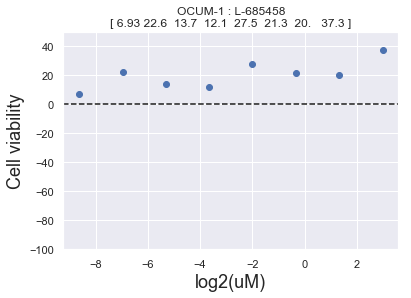

4292
4293
4294
4295
4296
4297
4298
4299
4300
4301
4302
4303
4304
4305
4306
4307
4308
4309
4310
4311
4312
4313
4314
4315
4316
4317
4318
4319
4320
4321
4322
4323
4324
4325
4326
4327
4328
4329
4330
4331
4332
4333
4334
4335
4336
4337
4338
4339
4340
4341
4342
4343
4344
4345
4346
4347
4348
4349
4350
4351
4352
4353
4354
4355
4356
4357
4358
4359
4360
4361
4362
4363
4364
4365
4366
4367
4368
4369
4370
4371
4372
4373
4374
4375
4376
4377
4378
4379
4380
4381
4382
4383
4384
4385
4386
4387
4388
4389
4390
4391
4392
4393
4394
4395
4396
4397
4398
4399
4400
4401
4402
4403
4404
4405
4406
4407
4408
4409
4410
4411
TEN L-685458


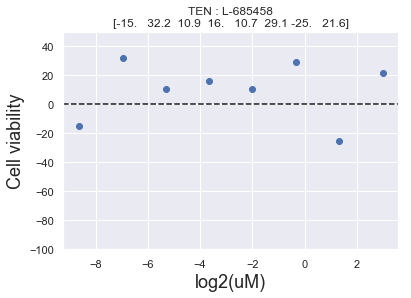

4412
4413
4414
4415
4416
4417
4418
4419
4420
4421
4422


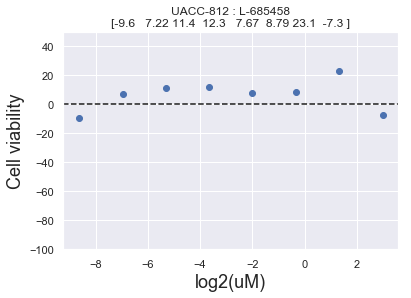

4423
4424
4425
4426
4427
4428
4429
4430
4431
4432
4433
4434
4435
4436
4437
4438
4439
4440
4441
4442
4443
4444
4445
4446
4447
4448
4449
4450
4451
4452
4453
4454
4455
4456
4457
4458
4459
4460
4461
4462
4463
4464
4465
BL-41 ZD-6474


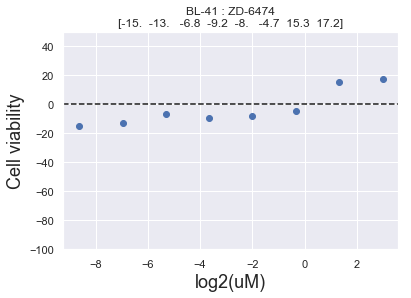

4466
4467
4468
4469
4470
4471
4472
4473
4474
4475
4476
4477
4478
4479
4480
4481
4482
4483
4484
4485
4486
4487
4488
4489
4490
4491
4492
4493
4494
4495
4496
4497
4498
4499
4500
4501
4502
4503
4504
4505
4506
4507
4508
4509
4510
4511
4512
4513
4514
4515
4516
4517
4518
4519
4520
4521
4522
4523
4524
4525
4526
4527
4528
4529
4530


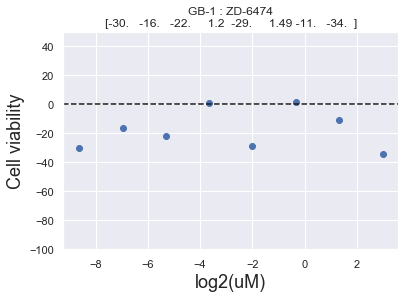

4531
4532
4533
4534
4535
4536
4537
4538
4539
4540
4541
4542
4543
4544
4545
4546
4547
4548
4549
4550
4551
4552
4553
4554
4555
4556
4557
4558
4559
4560
4561
4562
4563
4564
4565
4566
4567
4568
4569
4570
4571
4572
4573
4574
4575
4576
4577
4578
4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589
4590
4591
4592
4593
4594
4595
4596
4597
4598
4599
4600
4601
4602
4603
4604
4605
4606
4607
4608
4609
4610
4611
4612
4613
4614
4615
4616
4617
4618
4619
4620
JM1 ZD-6474


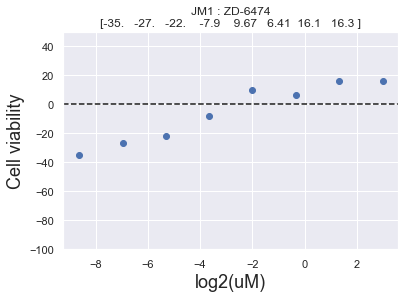

4621
4622
4623
4624
4625
4626
4627
4628
4629
4630
4631
4632


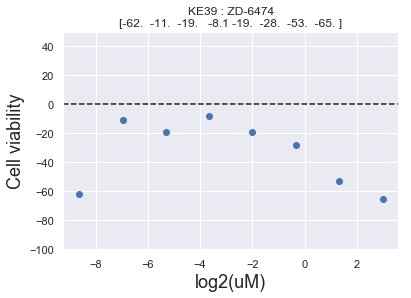

4633
4634
4635
4636
4637
4638
4639
4640
4641
4642
4643
4644
4645
4646
4647
4648
4649
4650
4651
4652
4653
4654
4655
4656
4657
4658
4659
4660
4661
4662
4663
4664
4665
4666
4667
4668
4669
4670
4671
4672
4673
4674
4675
4676
LP-1 ZD-6474


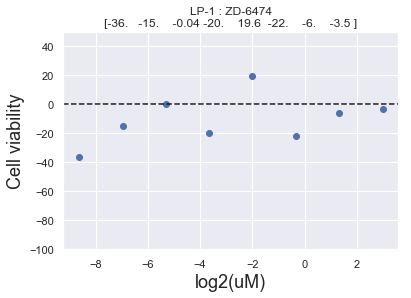

4677
4678
4679
4680
4681
4682
4683
4684
4685
4686
4687
4688
4689
4690
4691
4692
4693
4694
4695
4696
4697
4698
4699
4700
4701
4702
4703
4704
4705
4706
4707
4708
4709
4710
4711
4712
MOLP-8 ZD-6474


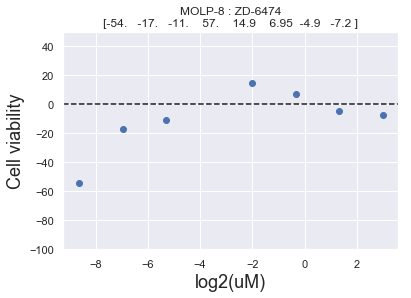

4713
4714
4715


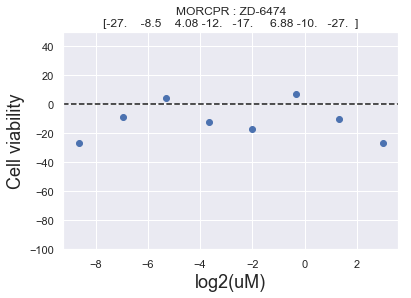

4716
4717
4718
4719
4720
4721
NCI-H1184 ZD-6474


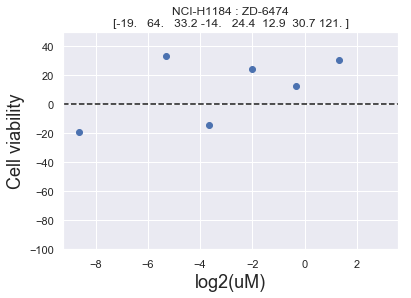

4722
4723
4724
4725
4726
4727
4728
4729
4730
4731
4732
4733
4734
4735
4736
4737
4738
4739
4740
4741
4742
4743
4744
4745
4746
4747
4748
4749
4750
4751
4752
4753
NCI-H2172 ZD-6474


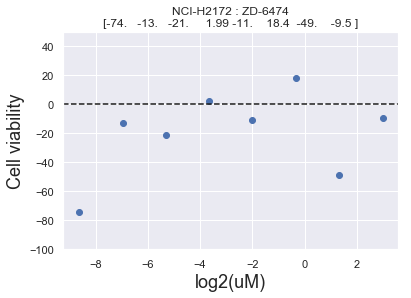

4754
4755
4756
4757
NCI-H23 ZD-6474


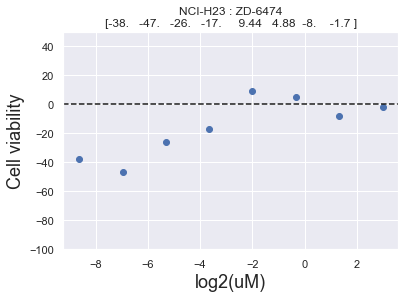

4758
4759
4760
4761
4762
4763
4764
4765
4766
4767
4768
4769
4770
4771
4772
4773
4774
4775
4776
4777
4778
4779
4780
4781
4782
4783
4784
OCILY10 ZD-6474


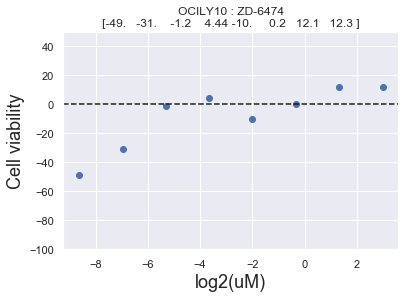

4785
4786
4787
4788
4789
4790
4791
4792
4793
4794
4795
4796
4797
4798
4799
4800
4801
4802
4803
4804
4805
4806
4807
4808
4809
4810
4811
4812
4813
4814
4815
4816
4817
4818
4819
4820
4821
4822
4823
4824
4825
4826
4827
4828
4829
4830
4831
4832
4833
4834
4835
4836
4837
4838


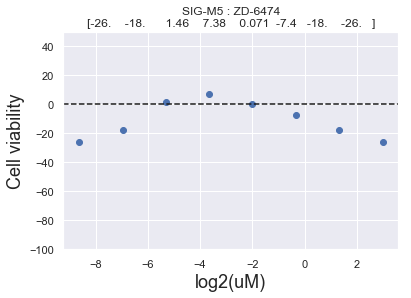

4839


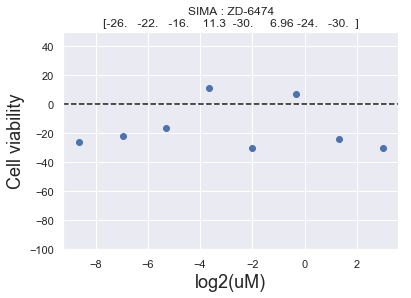

4840
4841
4842
4843
4844
4845
4846
4847
4848
4849
4850
4851
4852
4853
4854
4855
4856
4857
4858
4859
4860
4861
4862
4863
4864
4865
4866
4867
4868
4869
4870
4871
4872
4873
4874
4875
4876
4877
4878
4879
4880
4881
4882
4883
4884
4885
4886
4887
4888
4889
4890
4891
4892
4893
SW900 ZD-6474


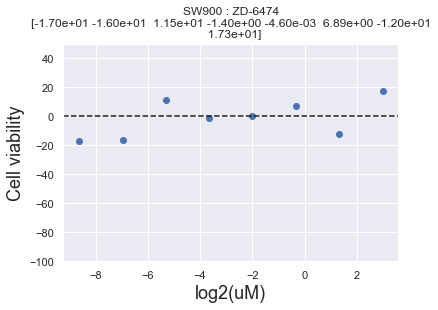

4894
4895
4896
4897
4898
4899
4900
4901
4902
4903
4904
4905
4906


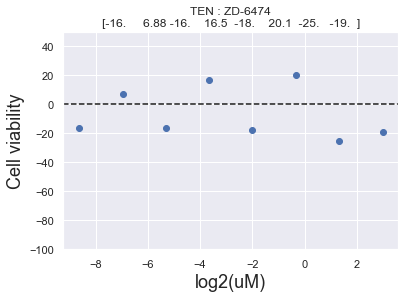

4907
4908
4909
4910
4911
4912
4913
4914
4915
4916
4917
4918
4919
4920
4921
4922
4923
4924
4925
4926


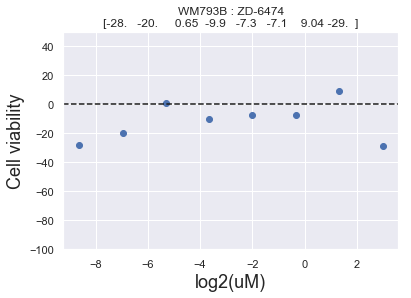

4927
4928
4929
4930
4931
4932
4933
4934
4935
4936
4937
4938
4939
4940
4941
4942
4943
4944
4945
4946
4947
4948
4949
4950
4951
4952
4953
4954
4955
4956
4957
4958
4959
4960
4961
4962
4963
4964
4965
4966
4967
4968
4969
4970
4971
4972
4973
4974
4975
4976
4977
4978
4979
4980
4981
4982
4983
4984
4985
4986
4987
4988
4989
4990
4991
4992
4993
4994
4995
4996
4997
4998
4999
5000
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126


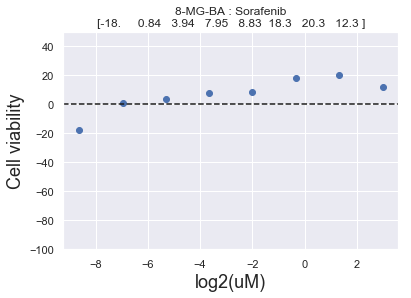

5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
BDCM Sorafenib


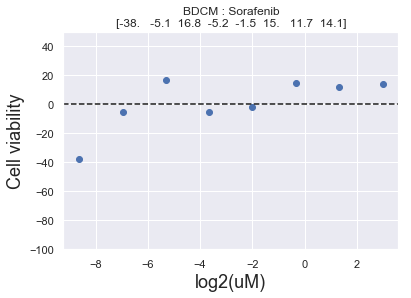

5460
5461
5462
5463


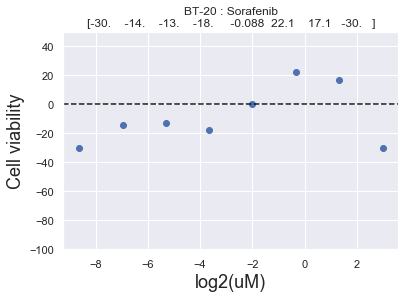

5464
5465
5466
5467
5468
5469
5470


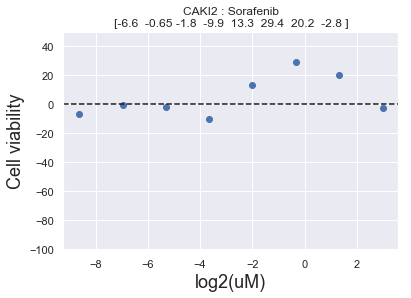

5471
5472
CAL-27 Sorafenib


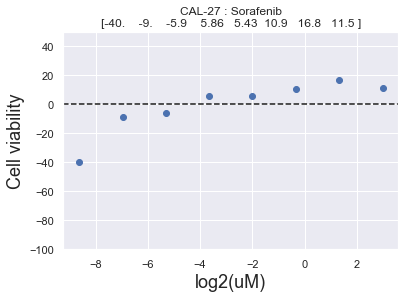

5473
5474
5475
5476
5477
5478
5479
5480
5481
CCK-81 Sorafenib


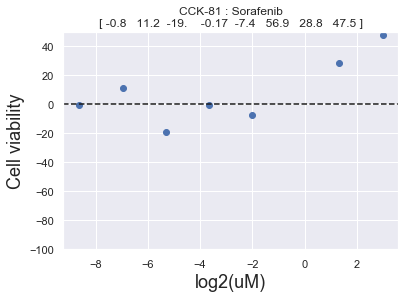

5482
5483
5484
CI1 Sorafenib


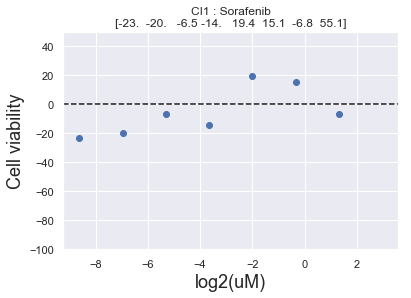

5485
5486
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498
5499
5500
5501
5502
5503
5504
5505
5506
5507


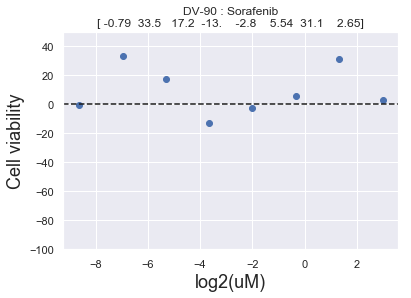

5508


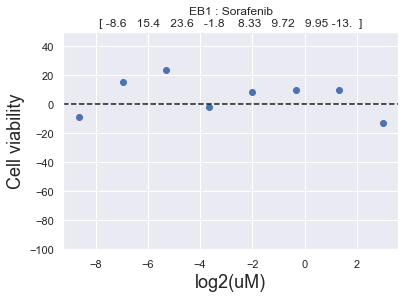

5509
5510
EBC-1 Sorafenib


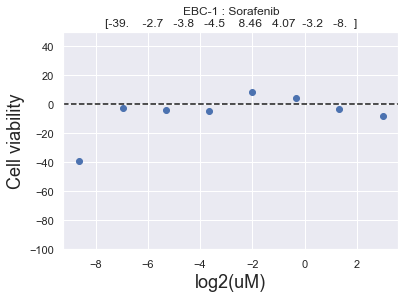

5511
5512
5513
5514
5515
5516
5517
5518
5519
5520
5521
5522
5523
5524
5525
5526
5527
5528
5529
5530
5531
5532
5533


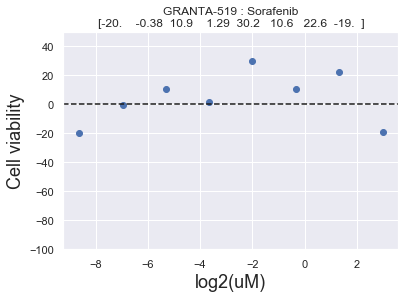

5534
5535
5536
HCC1187 Sorafenib


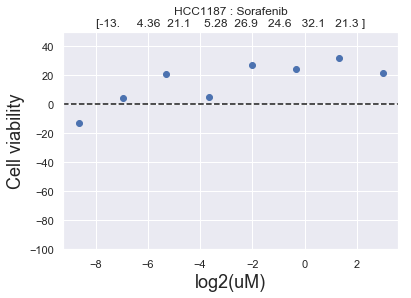

5537
5538
5539
5540
5541
5542
5543
5544
5545
HCC-56 Sorafenib


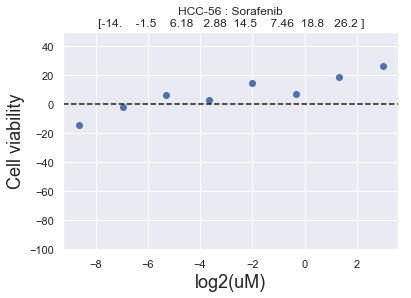

5546
5547
5548
HCC-827 Sorafenib


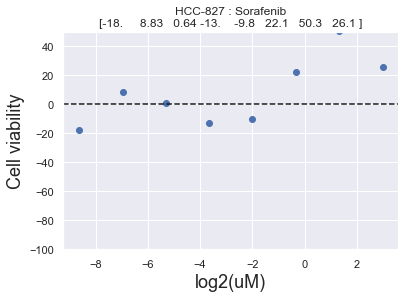

5549
5550
5551
5552
5553
5554
5555
5556
5557
5558
5559
5560
5561
5562
5563
5564
5565
5566
5567


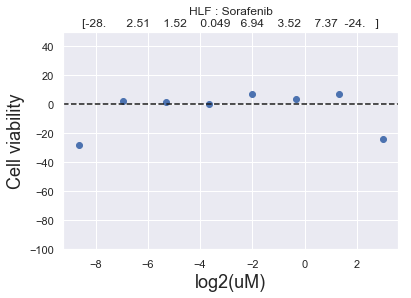

5568
5569
5570
5571
5572
HPAF-II Sorafenib


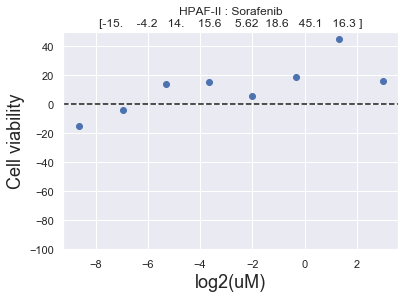

5573
HS229T Sorafenib


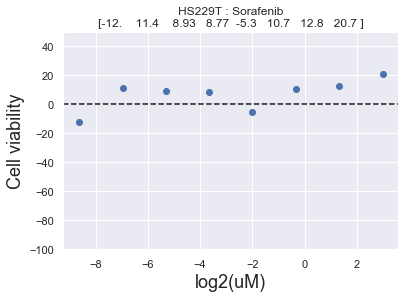

5574
5575
5576
5577
5578
5579
5580
5581
5582
HS840T Sorafenib


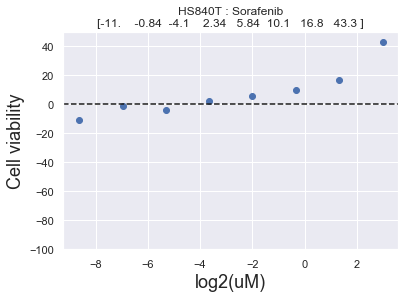

5583
5584
5585
5586
5587
5588
5589
5590
5591
5592
5593
5594
5595
5596
5597
HuP-T3 Sorafenib


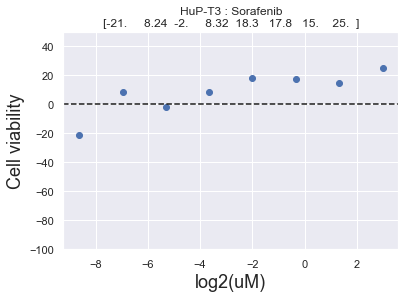

5598
5599
5600
5601
IGR-37 Sorafenib


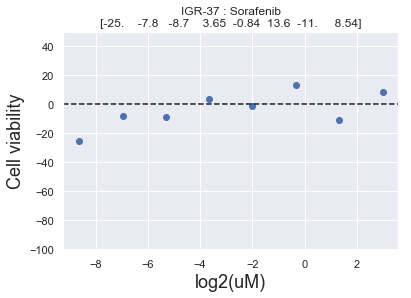

5602
5603
5604
IM-95 Sorafenib


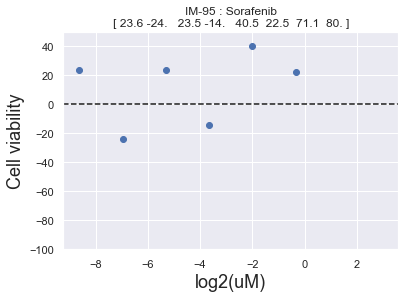

5605
5606
5607
5608
5609
5610
J82 Sorafenib


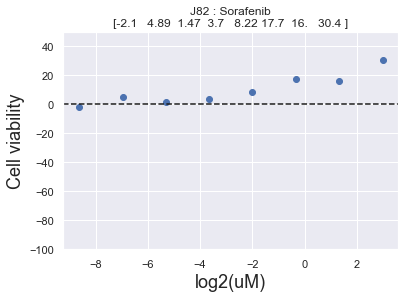

5611
5612
5613
5614
5615
5616
5617
5618
JHUEM2 Sorafenib


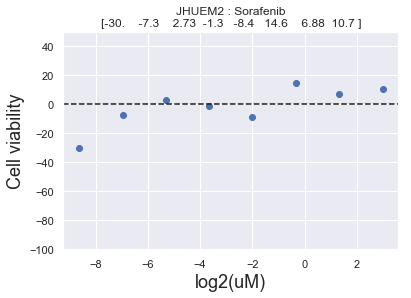

5619
5620
5621
5622
5623
5624
5625
5626
5627
5628
5629
5630
5631
5632
5633
5634
5635
5636
5637
5638
5639
5640
5641
5642
5643
5644
5645
5646
5647
5648
5649
5650
5651
5652
5653
5654
5655
5656
5657
5658
5659
5660
5661
5662
5663
5664
5665
5666
5667
5668
5669
5670
5671
5672
5673
5674
5675
5676
5677
5678
5679
5680
5681
5682
5683
5684
5685
5686
5687
5688
5689
5690
5691
5692
5693
5694
5695
5696
5697
5698
5699
5700
Mewo Sorafenib


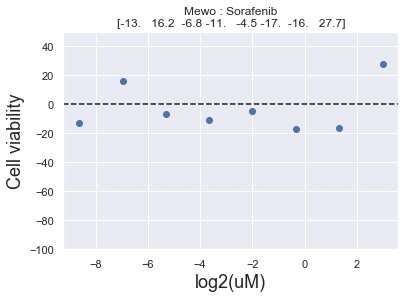

5701
5702
5703
MFE-319 Sorafenib


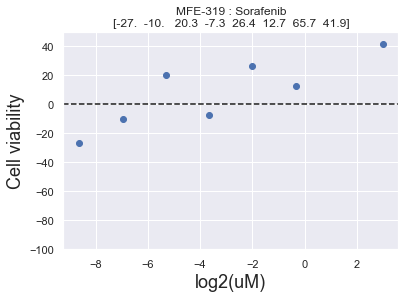

5704
5705
5706
5707
MINO Sorafenib


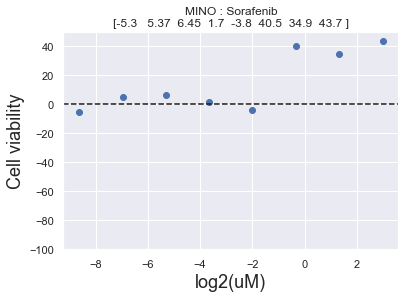

5708
5709
5710
5711
5712
5713
5714
5715
5716
5717
5718
5719
5720
5721
5722
5723
5724
5725


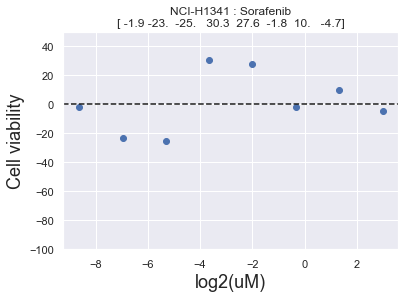

5726
5727
5728
5729
5730
5731
5732
5733
5734
5735
5736


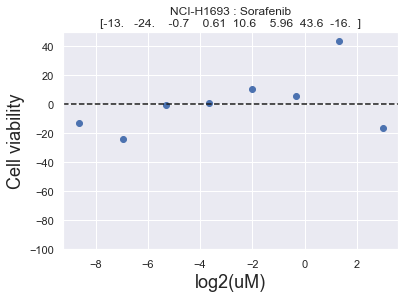

5737
5738
5739
5740
5741
5742
5743
NCI-H1944 Sorafenib


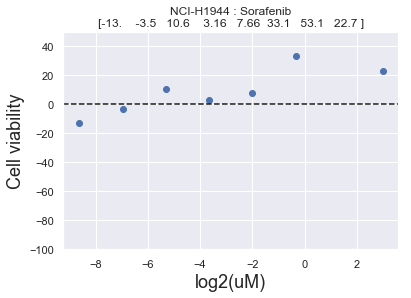

5744
5745
5746
5747
5748
5749
5750
5751
5752
5753
5754
NCI-H2172 Sorafenib


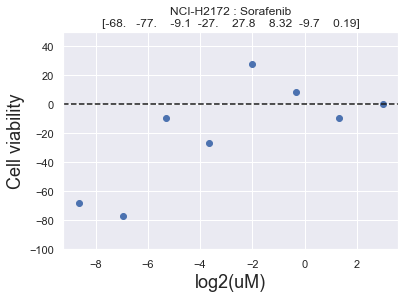

5755
5756
5757
5758
5759
5760
5761
5762
5763
5764
5765
5766
5767
5768
5769
5770
5771
5772
5773
5774
5775
5776
5777
5778
5779
5780
5781
5782
5783
5784
5785
5786
5787
5788
5789
5790
5791
5792
5793
5794
5795
5796
5797
5798
5799
5800
P3HR-1 Sorafenib


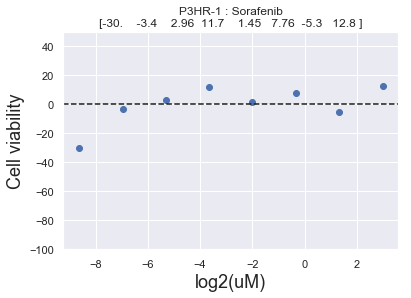

5801
5802
5803
5804
5805
5806
5807
5808
5809
5810
5811
5812
PL4 Sorafenib


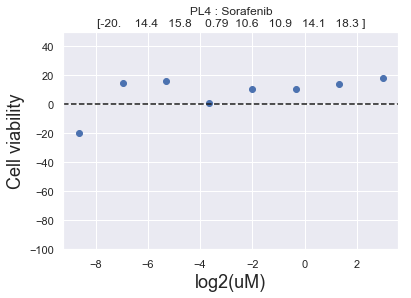

5813
5814
5815
5816
5817
5818
5819
5820
5821
RERF-LC-MS Sorafenib


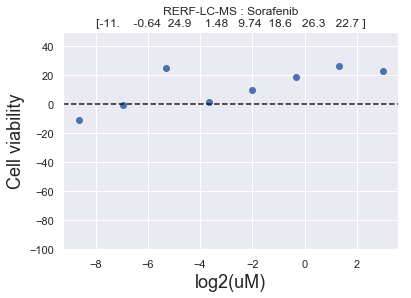

5822
5823
5824
RL95-2 Sorafenib


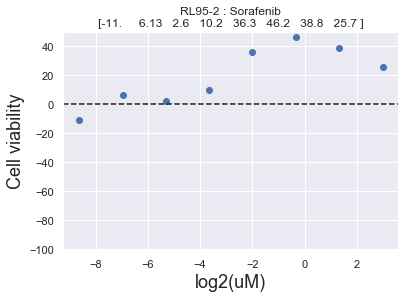

5825
5826
5827
5828
5829
5830
5831
5832
5833
SCC-25 Sorafenib


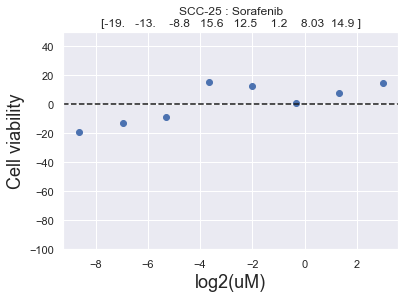

5834
5835
5836
5837
5838
5839
5840
5841
5842
5843
5844
5845
SK-CO-1 Sorafenib


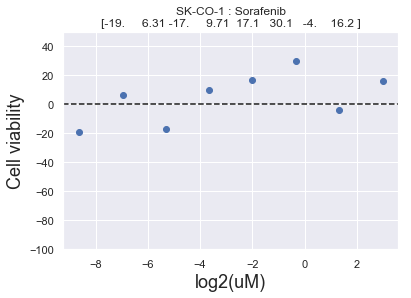

5846
5847
5848
5849
5850
5851
5852
5853
5854
5855
5856
5857
5858
5859
5860
SK-N-FI Sorafenib


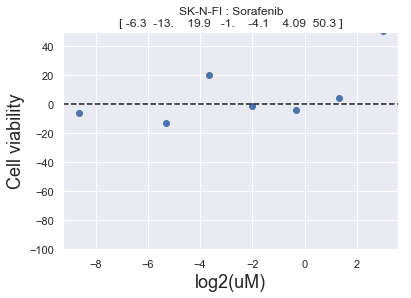

5861
5862
5863
5864
5865
5866
5867
5868
5869
5870
5871
5872
5873
5874
5875
5876
5877
5878
5879
5880
5881
SUP-M2 Sorafenib


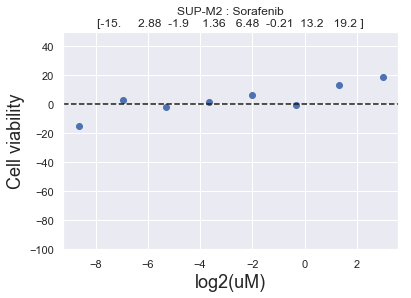

5882
5883
SW1088 Sorafenib


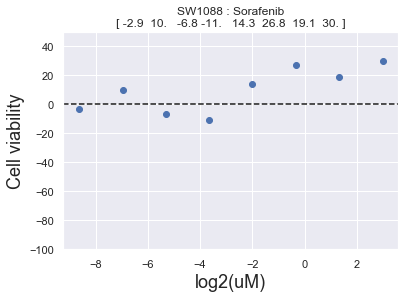

5884
5885
5886
5887
5888
5889
5890
5891
5892
5893
5894
5895
SW900 Sorafenib


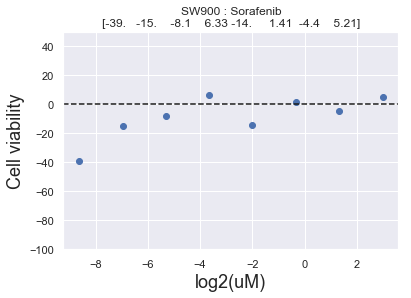

5896
5897
5898
5899
T84 Sorafenib


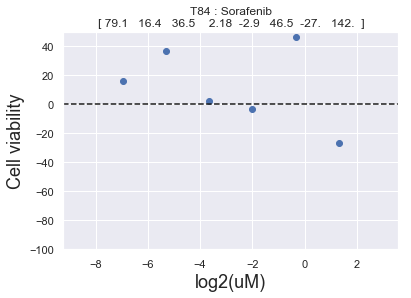

5900
5901
5902
5903
5904
5905
5906
5907
5908
5909
5910
5911
5912
5913


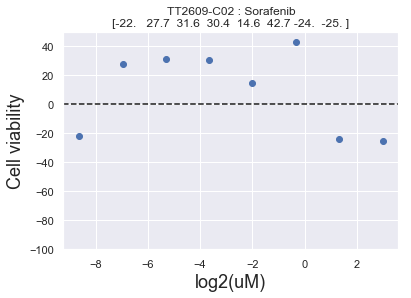

5914
5915
U-118-MG Sorafenib


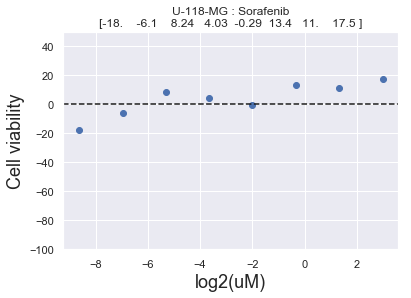

5916
5917
5918
5919
UACC-257 Sorafenib


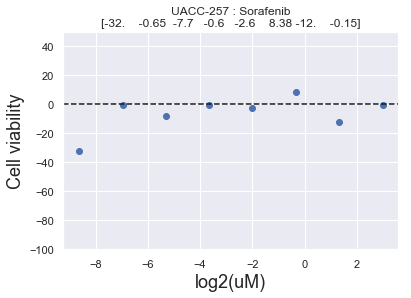

5920
5921
5922
5923
5924
5925
5926
WM-115 Sorafenib


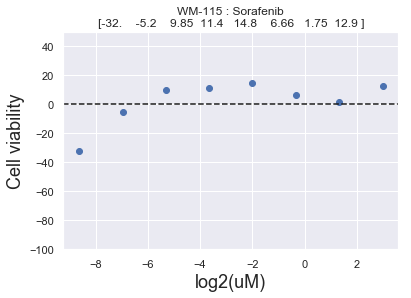

5927
5928
5929
5930
5931
5932
5933
5934
5935
5936
5937
5938
5939
5940
5941
5942
5943
5944
5945
5946
5947
5948
5949
5950
5951
5952
5953
5954
5955
5956
5957
5958
5959
5960
5961
5962
5963
5964
5965
5966
5967
5968
5969
5970
5971
5972
5973
5974
5975
5976
5977
5978
5979
5980
5981
5982
5983
5984
5985
5986
5987
5988
5989
5990
5991
5992
5993
5994
5995
5996
5997
5998
5999
6000
6001
6002
6003
6004
6005
6006
6007
6008
6009
6010
6011
6012
6013
6014
6015
6016
6017
6018
6019
6020
6021
6022
6023
6024
6025
6026
6027
6028
6029
6030
6031
6032
6033
6034
6035
6036
6037
6038
6039
6040
6041
6042
6043
6044
6045
6046
6047
6048
6049
6050
6051
6052
6053
6054
6055
6056
6057
6058
6059
6060
6061
6062
6063
6064
6065
6066
6067
6068
6069
6070
6071
6072
6073
6074
6075
6076
6077
6078
6079
6080
6081
6082
6083
6084
6085
6086
6087
6088
6089
6090
6091
6092
6093
6094
6095
6096
6097
6098
6099
6100
6101
6102
6103
6104
6105
6106
6107
6108
6109
6110
6111
6112
6113
6114
6115
6116
6117
6118
6119
6120
6121
6122
6123
6124
6125
6126


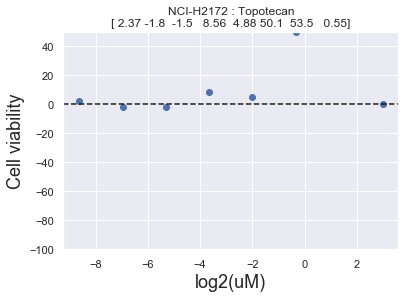

6576
6577
6578
6579
6580
6581
6582
6583
6584
6585
6586
6587
6588
6589
6590
6591
6592
6593
6594
6595
6596
6597
6598
6599
6600
6601
6602
6603
6604
6605
6606
6607
6608
6609
6610
6611
6612
6613
6614
6615
6616
6617
6618
6619
6620
6621
6622
6623
6624
6625
6626
6627
6628
6629
6630
6631
6632
6633
6634
6635
6636
6637
6638
6639
6640
6641
6642
6643
6644
6645
6646
6647
6648
6649
6650
6651
6652
6653
6654
6655
6656
6657
6658
6659
6660
6661
6662
6663
6664
6665
6666
6667
6668
6669
6670
6671
6672
6673
6674
6675
6676
6677
6678
6679
6680
6681
6682
6683
6684
6685
6686
6687
6688
6689
6690
6691
6692
6693
6694
6695
6696
6697
6698
6699
6700
6701
6702
6703
6704
6705
6706
6707
6708
6709
6710
6711
6712
6713
6714
6715
6716
6717
6718
6719
6720
6721
6722
6723
6724
6725
6726
6727
6728
6729
6730
6731
6732
6733
6734
6735
6736
6737
6738
6739
6740
6741
6742
6743
6744
6745
6746
6747
6748
6749
6750
6751
6752
6753
6754
6755
6756
6757
6758
6759
6760
6761
6762


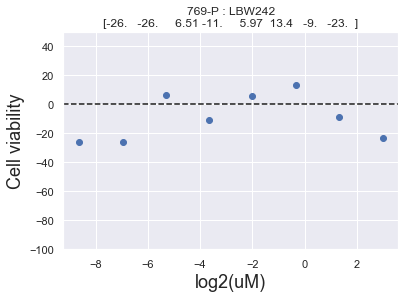

6763
6764
6765
6766
6767
6768
6769
6770
6771
6772
6773
6774
6775
6776
6777
6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788


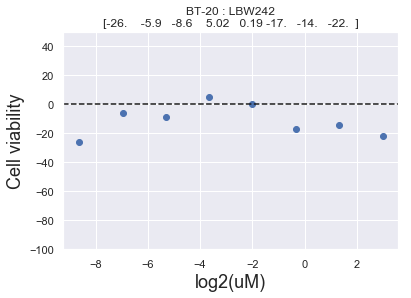

6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
CHP-212 LBW242


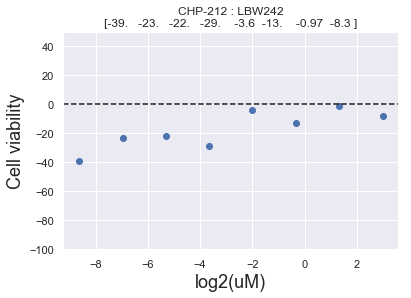

6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
COV504 LBW242


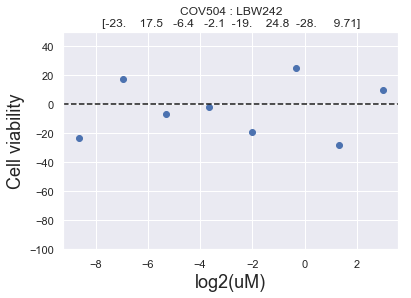

6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
EB2 LBW242


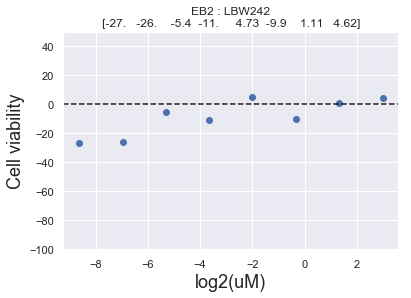

6835


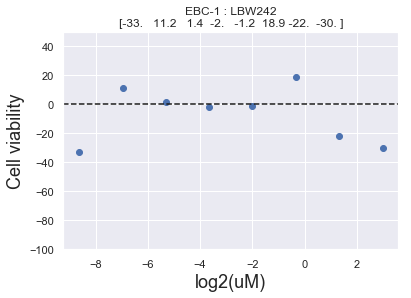

6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
FU-OV-1 LBW242


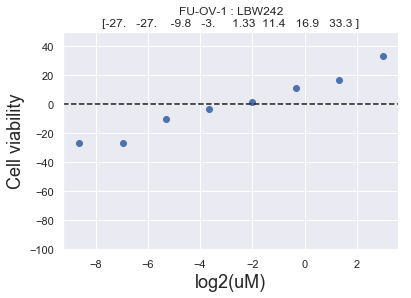

6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
GRANTA-519 LBW242


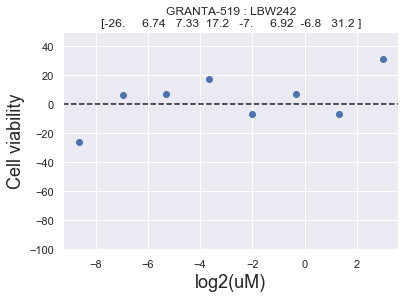

6859
6860
6861
6862
6863
6864


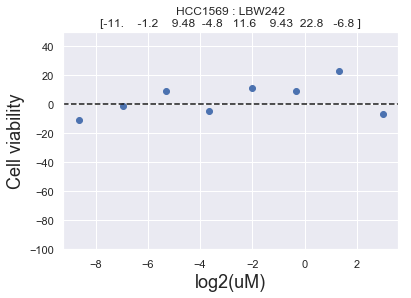

6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
HPAF-II LBW242


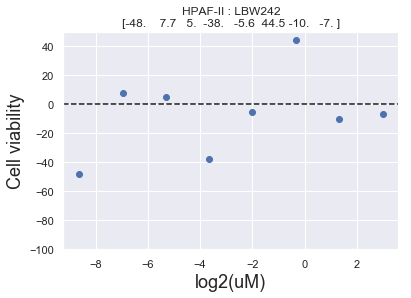

6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
IA-LM LBW242


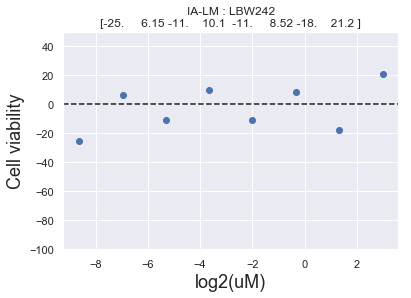

6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
JM1 LBW242


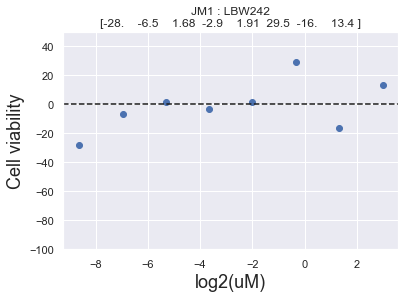

6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
KMS34 LBW242


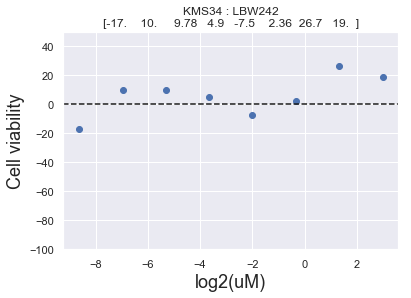

6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015


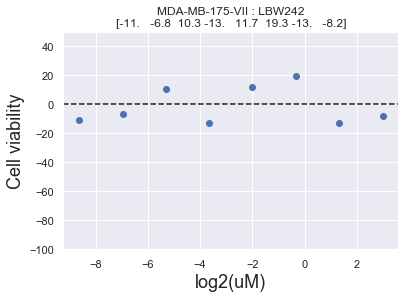

7016
7017
7018
7019
7020
7021
7022
7023
7024
7025


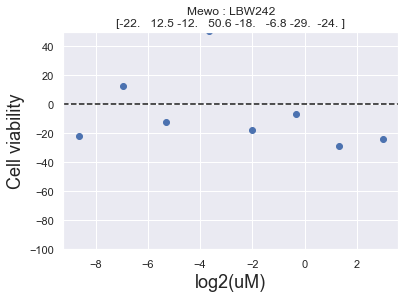

7026
7027
MFE-296 LBW242


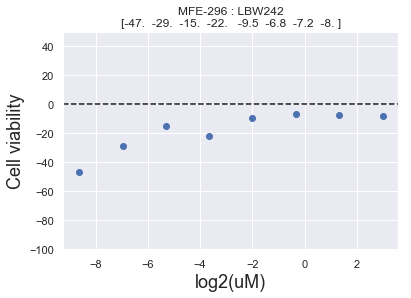

7028
MFE-319 LBW242


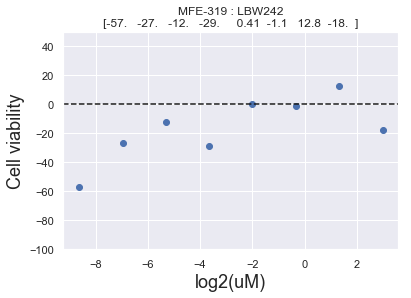

7029
MG-63 LBW242


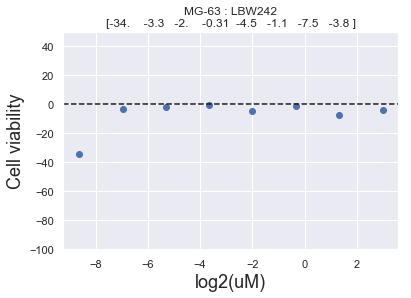

7030
7031
7032
7033
MJ LBW242


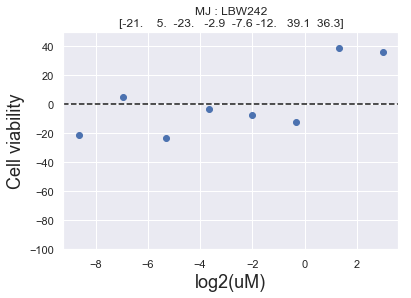

7034
7035
7036
7037
7038
MOLP-8 LBW242


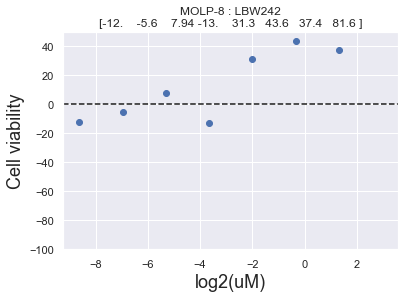

7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093
7094
7095
7096
7097
7098


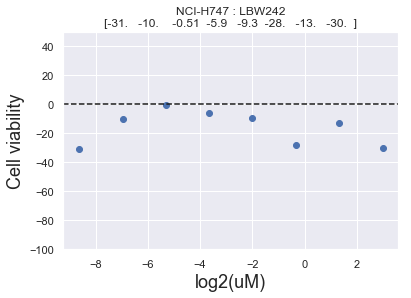

7099
7100
7101
7102
7103
7104
7105
7106
7107
7108
7109
7110
OCILY10 LBW242


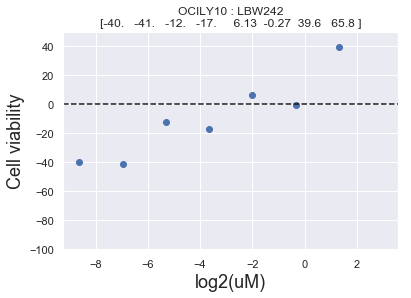

7111
7112
7113
7114
7115
7116
7117
7118
7119
7120
7121
7122
7123
7124
7125
7126
7127
7128


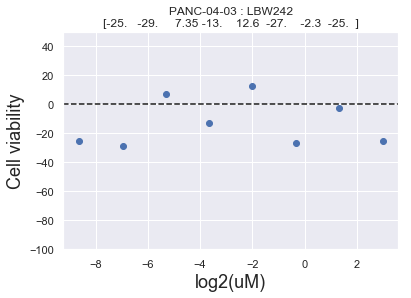

7129
7130
7131
7132
7133
7134
7135
7136
7137
7138
7139
7140
QGP-1 LBW242


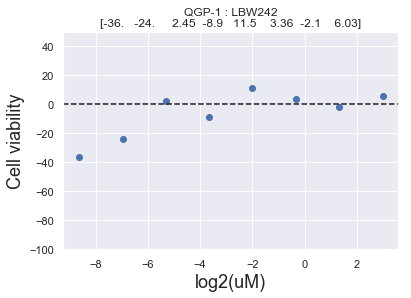

7141
7142
7143
7144
7145
7146
7147
7148
7149
7150
7151
7152
RT4 LBW242


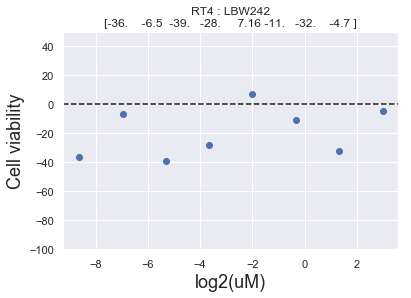

7153
7154
7155
7156
7157
7158
7159
7160
7161
7162
7163
SHP-77 LBW242


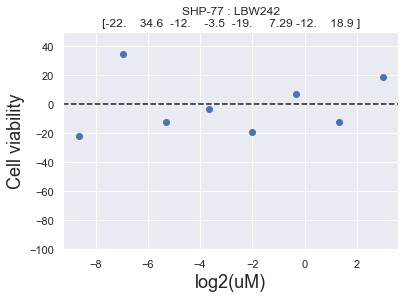

7164
7165
SIMA LBW242


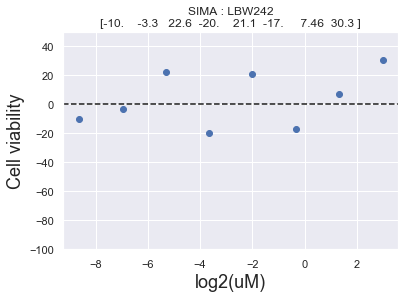

7166
7167
7168
7169
7170
7171
7172
7173
7174
7175
7176
7177
7178
7179
7180
7181
7182
7183
7184
7185
7186
7187
7188
7189
7190
7191
7192
7193
7194
7195
SNU-475 LBW242


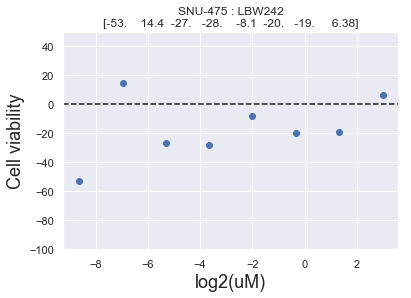

7196


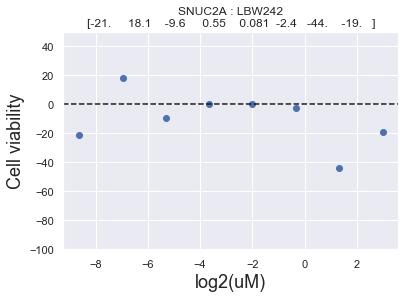

7197
7198
7199
7200
7201
7202
7203
7204
7205
7206
SUP-T1 LBW242


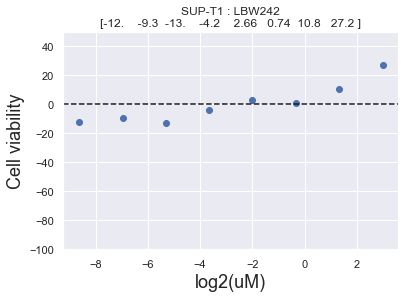

7207
7208
7209
7210
7211
7212
7213
7214
7215
7216
7217
7218
7219
7220
T-24 LBW242


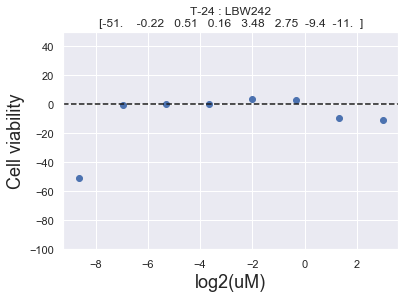

7221
7222
7223
7224
7225
7226
7227
7228
7229
7230
7231
7232
7233
7234
7235
7236
7237
TT2609-C02 LBW242


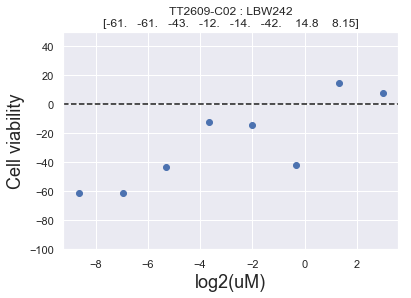

7238
7239
7240
7241
7242
7243
7244
7245
7246
7247
VMRC-LCD LBW242


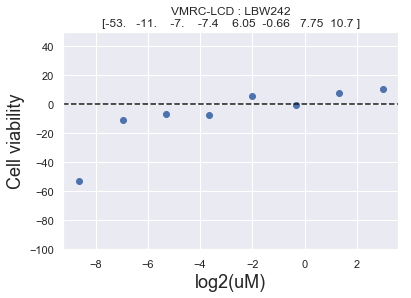

7248
7249
7250
7251
7252
7253
7254
7255
7256
YKG-1 LBW242


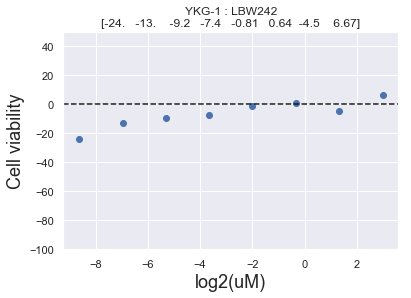

7257
ZR751 LBW242


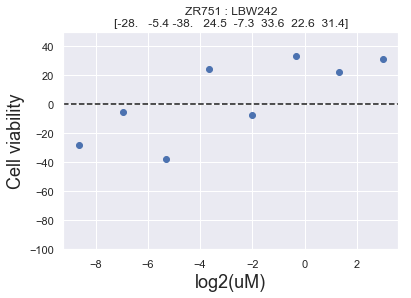

7258
7259
7260
7261
7262
7263
7264
7265
7266
7267
7268
7269
7270
7271
7272
7273
7274
7275
7276
7277
7278
7279
7280
7281
7282
7283
7284
7285
7286
7287
7288
7289
7290
7291
7292
7293
7294
7295
7296
7297
7298
7299
7300
7301
7302
7303
7304
7305
7306
7307
7308
7309
7310
7311
7312
7313
7314
7315
7316
7317
7318
7319
7320
7321
7322
7323
7324
7325
7326
7327
7328
7329
7330
7331
7332
7333
7334
7335
7336
7337
7338
7339
7340
7341
7342
7343
7344
7345
7346
7347
7348
7349
7350
7351
7352
7353
7354
7355
7356
7357
7358
7359
7360
7361
7362
7363
7364
7365
7366
7367
7368
7369
7370
7371
7372
7373
7374
7375
7376
7377
7378
7379
7380
7381
7382
7383
7384
7385
7386
7387
7388
7389
7390
7391
7392
7393
7394
7395
7396
7397
7398
7399
7400
7401
7402
7403
7404
7405
7406
7407
7408
7409
7410
7411
7412
7413
7414
7415
7416
7417
7418
7419
7420
7421
7422
7423
7424
7425
7426
7427
7428
7429
7430
7431
7432
7433
7434
7435
7436
7437
7438
7439
7440
7441
7442
7443
7444
7445
7446
7447
7448
7449
7450
7451
7452
7453
7454
7455
7456
7457


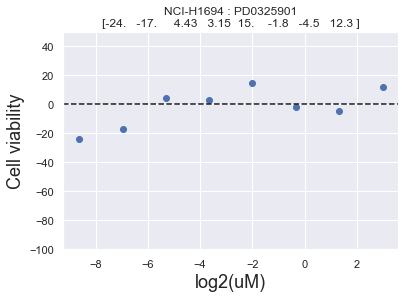

7566
7567
7568
7569
7570
7571
7572
7573
7574
7575
7576
7577
7578
7579
7580
7581
7582
7583
7584
7585
7586
7587
7588
7589
7590
7591
7592
7593
7594
7595
7596
7597
7598
7599
7600
7601
7602
7603
7604
7605
7606
7607
7608
7609
7610
7611
7612
7613
7614
7615
7616
7617
7618
7619
7620
7621
7622
7623
7624
7625
7626
7627
7628
7629
7630
7631
7632
7633
7634
7635
7636
7637
7638
7639
7640
7641
7642
7643
7644
7645
7646
7647
7648
7649
7650
7651
7652
7653
7654
7655
7656
7657
7658
7659
7660
7661
7662
7663
7664
7665
7666
7667
7668
7669
7670
7671
7672
7673
7674
7675
7676
7677
7678
7679
7680
7681
7682
7683
7684
7685
7686
7687
7688
7689
7690
7691
7692
7693
7694
7695
7696
7697
7698
7699
7700
7701
7702
7703
7704
7705
7706
7707
7708
7709
7710
7711
7712
7713
7714
7715
7716
7717
7718
7719
7720
7721
7722
7723
7724
7725
7726
7727
7728
7729
7730
7731
7732
7733
7734
7735
7736
7737
7738
7739
7740
7741
7742
7743
7744
7745
7746
7747
7748
7749
7750
7751
7752
7753
7754
7755
7756
7757
7758
7759
7760
7761
7762


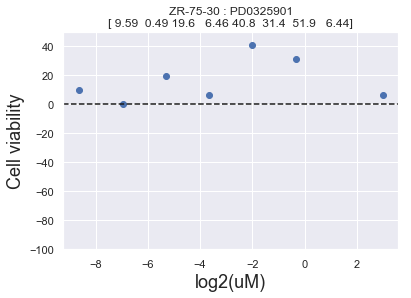

7763
7764
7765
7766
7767
7768
7769
7770
7771
7772
7773
7774
7775
7776
7777
7778
7779
7780
7781
7782
7783
7784
7785
7786
7787
7788
7789
7790
7791
BT-20 Palbociclib


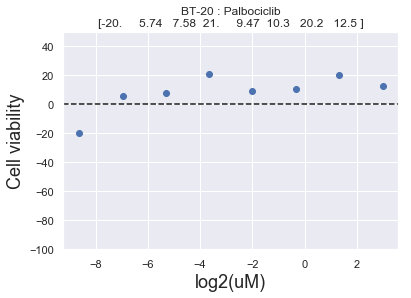

7792
7793
7794
7795
7796
7797
7798
7799
7800
7801
7802
7803
7804
7805
7806
7807
7808
7809
7810
7811
7812
7813
7814
7815
7816
7817
7818
7819
7820
7821
7822
7823
7824
7825
7826
7827
7828
7829
7830
7831
7832
7833
7834
7835
7836
7837
7838
7839
7840
7841
7842
7843
7844
7845
7846
7847
7848
7849
7850
7851
7852
7853
7854
7855
7856
7857
7858
7859
7860
7861
7862
7863
7864
7865
7866
7867
7868
7869
7870
7871


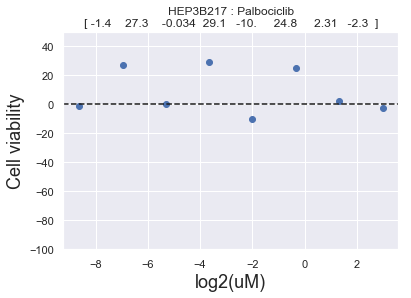

7872
7873
7874
7875
7876
7877
7878
7879
7880
7881
7882
7883
7884
7885
7886
7887
7888
7889
7890
7891
7892
7893
7894
7895
7896
7897
7898
7899
7900
7901
7902
7903
7904
7905
7906
7907
7908
7909
7910
7911
7912
7913
7914
7915
7916
7917
7918
7919
7920
7921
7922
7923
7924
7925
7926
7927
7928
7929
7930
7931
7932
7933
7934
7935
7936
7937
7938
7939
7940
7941
7942
7943
7944
7945
7946
7947
7948
7949
7950
7951
7952
7953
7954
7955
7956
7957
7958
7959
7960
7961
7962
7963
7964
7965
7966
7967
7968
7969
7970
7971
7972
7973
7974
7975
7976
7977
7978
7979
7980
7981
7982
7983
7984
7985
7986
7987
7988
7989
7990
7991
7992
7993
7994
7995
7996
7997
7998
7999
8000
8001
MKN7 Palbociclib


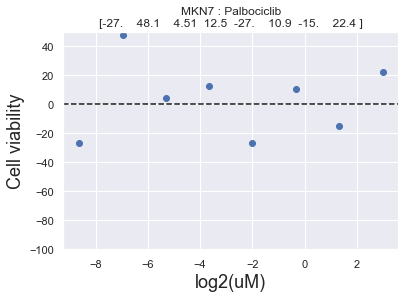

8002
8003
8004
8005
8006
8007
8008
8009
8010
8011


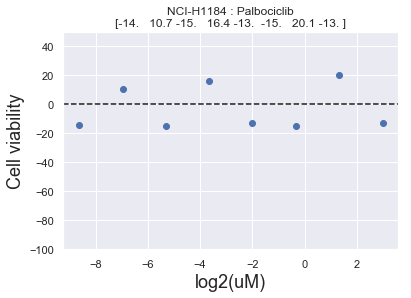

8012
8013
8014
8015
8016
8017
8018
8019
8020
8021
8022
8023
8024
8025
NCI-H1694 Palbociclib


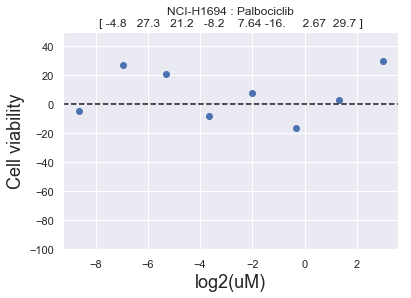

8026
8027
8028


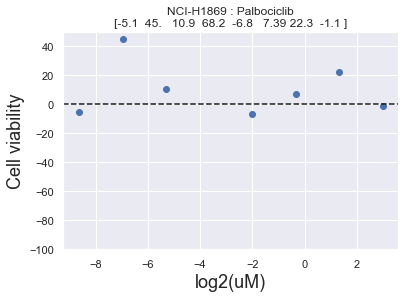

8029
8030
8031
8032
8033
8034
8035
8036
8037
8038
8039
8040
8041
8042
8043
8044
8045
8046
8047
8048
8049
8050
8051
8052
8053
8054
8055
8056
8057
8058
8059
8060
8061
8062
8063
8064
8065
8066
8067
8068
8069
8070
8071
8072
8073
8074
8075
8076


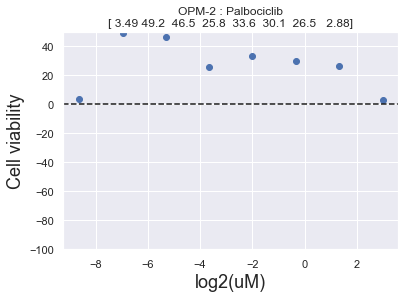

8077
8078
8079
8080
8081
8082
8083
8084
8085
8086
8087
8088
8089
8090
8091
8092
8093
8094
8095
8096
8097
8098
8099
8100
8101
8102
8103
8104
8105
8106
8107
8108
8109
8110
8111
8112
8113
8114
8115
8116


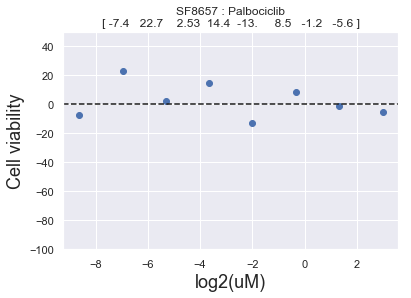

8117
8118
8119
8120
8121
8122
8123
8124
8125
8126
8127
8128
SK-MEL-2 Palbociclib


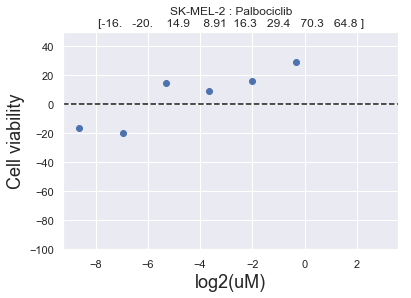

8129
8130
8131
8132
8133
8134
8135
8136
8137
8138
8139
8140
8141
8142
8143
8144
8145
8146
8147
8148
8149
8150
8151
8152
8153
8154


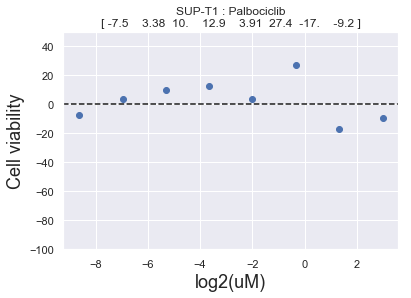

8155
8156
8157
8158
8159
8160
8161
8162
8163
8164
8165
8166
8167
8168
8169
8170
8171
8172
TC-71 Palbociclib


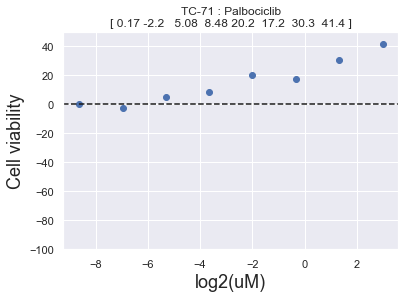

8173
8174
8175
8176
8177
8178
8179
8180
8181
8182
8183
8184
8185
8186
8187
8188
8189
8190
8191
8192
8193
8194
8195
8196
8197
8198
8199
8200
8201
8202
8203
8204
8205
8206
8207
8208
8209
8210
8211
8212
8213
8214
8215
8216
8217
8218
8219
8220
8221
8222
8223
8224
8225
8226
8227
8228
8229
8230
8231
8232
8233
8234
8235
8236
8237
8238
8239
8240
8241
8242
8243
8244
8245
8246
8247
8248
8249
8250
8251
8252
8253
8254
8255
8256
8257
8258
8259
8260
8261
8262
8263
8264
8265
8266
8267
8268
8269
8270
8271
8272
8273
8274
8275
8276
8277
8278
8279
8280
8281
8282
8283
8284
8285
8286
8287
8288
8289
8290
8291
8292
8293
8294
8295
8296
8297
8298
8299
8300
8301
8302
8303
8304
8305
8306
8307
8308
8309
8310
8311
8312
8313
8314
8315
8316
8317
8318
8319
8320
8321
8322
8323
8324
8325
8326
8327
8328
8329
8330
8331
8332
8333
8334
8335
8336
8337
8338
8339
8340
8341
8342
8343
8344
8345
8346
8347
8348
8349
8350
8351
8352
8353
8354
8355
8356
8357
8358
8359
8360
8361
8362
8363
8364
8365
8366
8367
8368
8369
8370
8371
8372


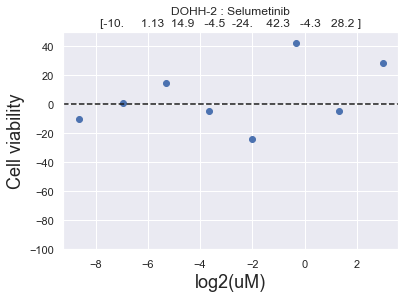

8774
8775
8776
8777


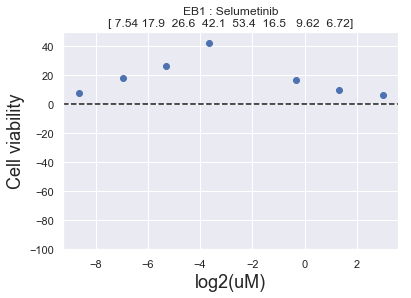

8778
8779
8780
8781
8782
8783
8784
8785
8786
8787
8788
8789
8790
8791
8792
8793
8794
8795
8796
8797
8798
8799
8800
8801
8802
8803
8804
8805
8806
8807
8808
8809
8810
8811
8812
8813
8814
8815
8816
8817
8818
8819
8820
8821
8822
8823
8824
8825
8826
8827
8828
8829
8830
8831
8832
8833
8834
8835
8836
8837
8838
8839
8840
8841
8842
8843
8844
8845
8846
8847
8848
8849
8850
8851
8852
8853
8854
8855
8856
8857
8858
8859
8860
8861
8862
8863
8864
8865
8866
8867
8868
8869
8870
8871
8872
8873
8874
8875
8876
8877
8878
8879
8880
8881
8882
8883
8884
8885
8886
8887
8888
8889
8890
8891
8892
8893
8894
8895
8896
8897
8898
8899
8900
8901
8902
8903
8904
8905
8906
8907
8908
8909
8910
8911
8912
8913
8914
8915
8916
8917
8918
8919
KP-1N Selumetinib


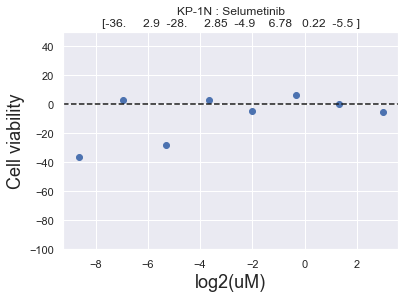

8920
8921
8922
8923
8924
8925
8926
8927
8928
8929
8930
8931
8932
8933
8934
8935
8936
8937
8938
8939
8940
8941
8942
8943
8944
8945
8946
8947
8948
8949
8950
8951
8952
8953
8954
8955
8956
8957
8958
8959
8960
8961
8962
8963
8964
8965
8966
8967
8968
8969
8970
8971
8972
8973
8974
8975
8976
8977
8978
8979
8980
8981
8982
8983
MOLT-16 Selumetinib


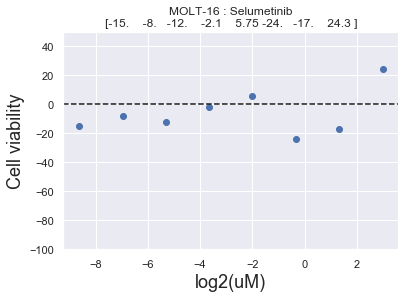

8984
8985
8986
8987
8988
8989
NCI-H1092 Selumetinib


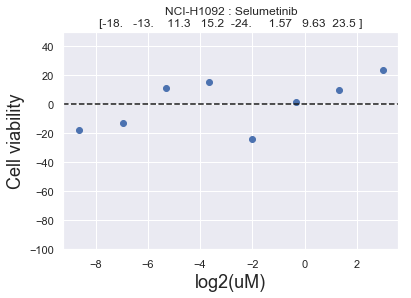

8990
8991
8992
8993
8994
8995
8996
8997
8998
8999
9000
9001
9002
9003
9004
9005


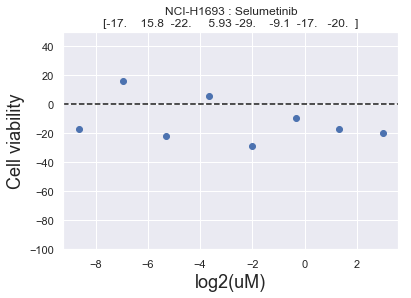

9006
NCI-H1694 Selumetinib


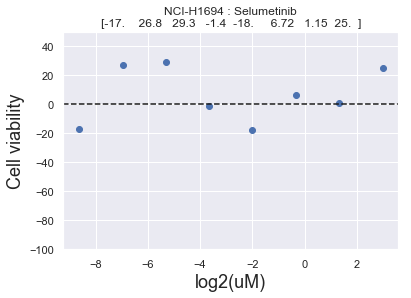

9007
9008
9009
9010
9011
9012
9013
9014
9015
9016
9017
9018
9019
9020
9021
9022
9023


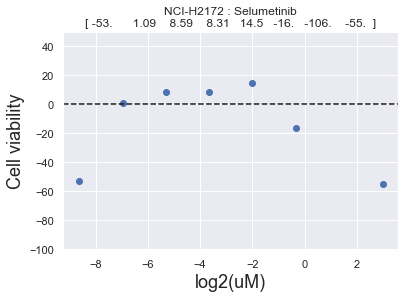

9024
9025
9026
9027
9028
9029
9030
9031
9032
9033
9034
9035
9036
9037
9038
9039
9040
9041
9042
9043
9044
9045
9046
9047
9048
9049
9050
9051
9052
9053
9054
OCILY10 Selumetinib


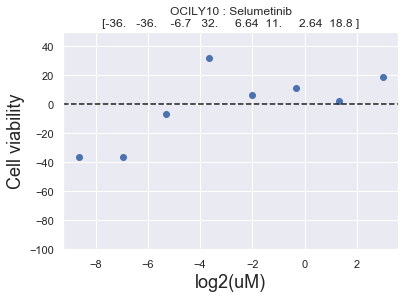

9055
9056
9057
9058
9059
9060
9061
9062
9063
9064
9065
9066
9067
9068
9069
9070
9071
9072
9073
9074
9075
9076
9077
9078
9079
9080
9081
9082
9083
9084
9085
9086
9087
9088
9089
9090
9091
9092
9093
9094
9095
9096
9097
9098
9099
9100
9101
9102
9103
9104
9105
9106
9107
SHP-77 Selumetinib


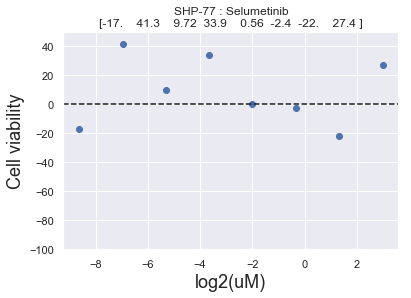

9108
9109
9110
9111
9112
9113
9114
SK-ES-1 Selumetinib


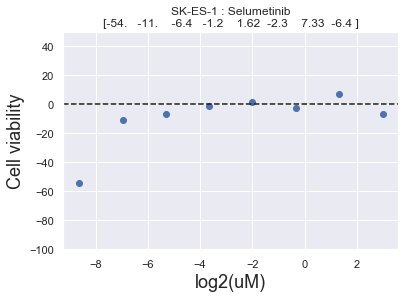

9115
9116
9117
9118
9119
9120
9121
9122
9123
9124
9125
9126
9127
9128
9129
9130
9131
9132
9133
SNU16 Selumetinib


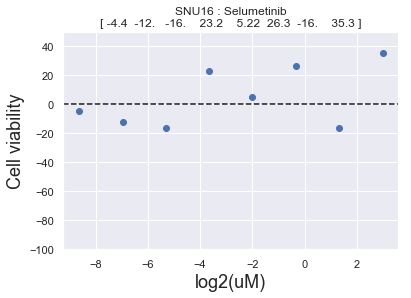

9134
9135
9136
9137
9138
9139
9140
9141
9142
9143
9144
9145
9146
9147
9148
9149
9150
9151
9152
9153
9154
9155
9156
9157
9158
9159
9160
9161
9162
9163
9164
9165
9166
9167
9168
9169
9170
9171
9172
9173
9174
9175
9176
9177
9178
9179
9180
9181
9182
9183
9184
9185
9186
9187
9188
9189
9190
9191
9192
VMRC-RCW Selumetinib


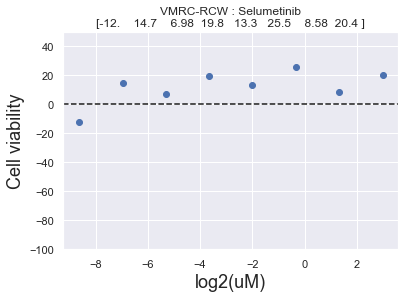

9193
9194
9195
9196
9197
9198
9199
9200
9201
9202
ZR-75-30 Selumetinib


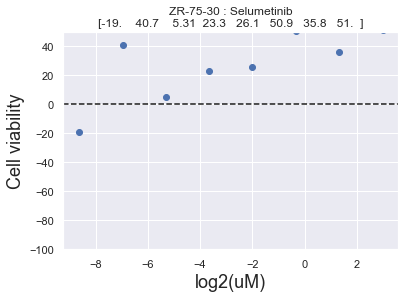

9203
9204
9205
9206
9207
9208
9209


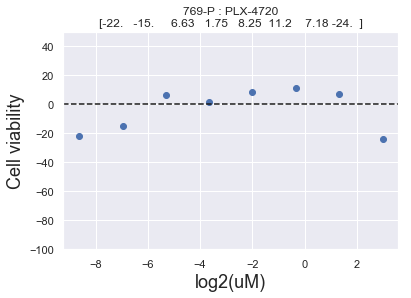

9210
9211
9212
9213
9214
9215
9216
9217
9218
9219
9220
9221
9222
9223
9224
9225
9226
9227
9228
9229
9230
9231
9232
9233
9234
9235
9236
9237
9238
9239
9240
9241
9242
9243
9244
9245
9246
9247
9248
9249
9250
9251
9252
9253
9254
9255
9256
9257
9258
9259
9260
9261
9262
9263
9264
9265
9266
9267
9268
9269
9270
9271
9272
9273
9274
9275
9276
9277
9278
9279
9280
9281
9282
9283
9284
9285
9286
9287
9288
9289
9290
9291
9292
9293
9294
9295


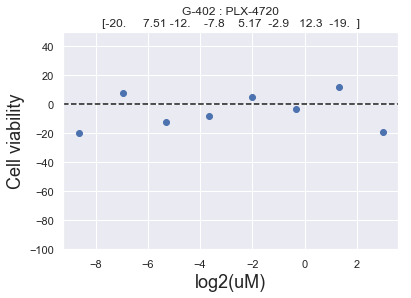

9296
9297
9298
9299
9300
9301
9302
9303
9304
9305
9306
9307
9308
9309
9310
9311
9312
HCC2935 PLX-4720


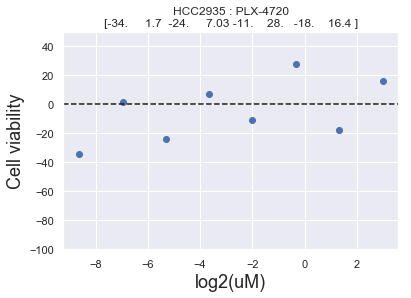

9313
9314
9315
9316
9317
9318
9319
9320
9321
9322
9323
9324
9325
9326
9327
9328
9329
9330
9331
9332
9333
9334
9335
9336
9337
9338
9339
9340


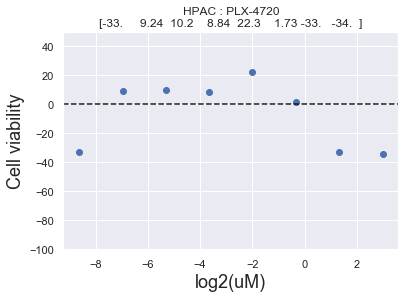

9341
9342
9343
9344
9345
9346
9347
9348
9349
9350
9351
9352
9353
9354
9355
9356
9357
9358
9359
9360
9361
9362
9363
9364
9365
9366
9367
9368
HUT78 PLX-4720


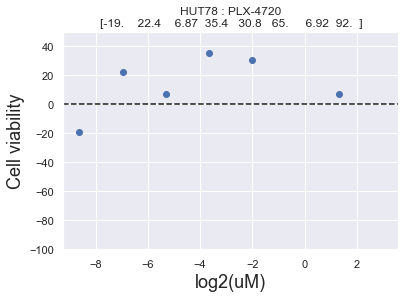

9369
9370
9371
9372
9373
9374
9375
9376
9377
9378
9379
9380
9381
9382
9383
9384
9385
9386
9387
9388
9389
9390
9391
9392
9393
9394
9395
9396
9397
9398
9399
9400
9401
9402
9403
9404
9405
9406


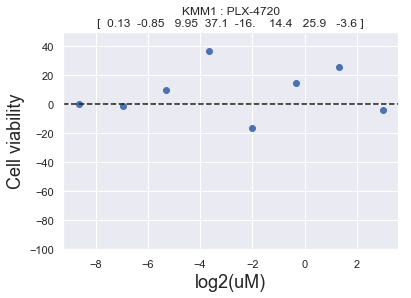

9407
9408
9409
9410
9411
9412
9413
9414
KNS60 PLX-4720


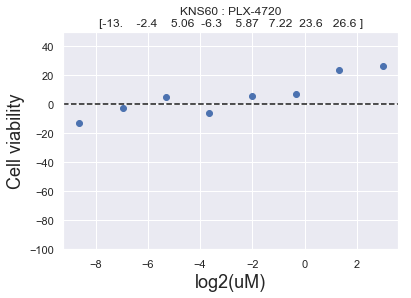

9415
9416
9417


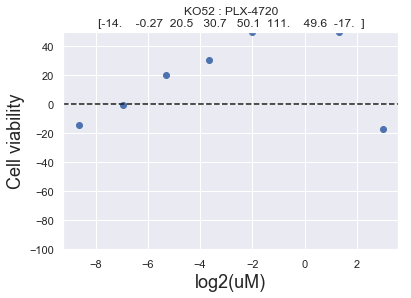

9418
9419
9420
9421
9422
9423
9424
9425
9426
9427
9428
9429
9430
9431
9432
9433
9434
9435
9436
9437
9438
9439
9440
9441
9442
9443
9444
9445
9446
9447
9448
9449
9450
9451


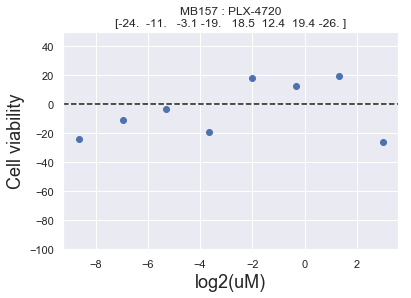

9452
9453
9454
9455
9456
9457
9458
9459
9460
9461
9462
9463
9464
9465
9466
9467
9468
9469
9470
9471
9472
9473
9474
9475
9476
9477


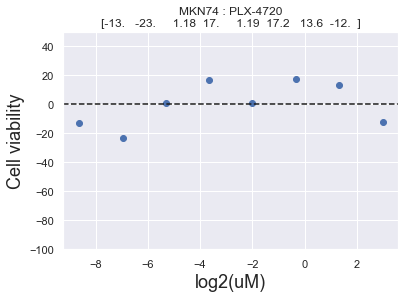

9478
9479
MOLP-8 PLX-4720


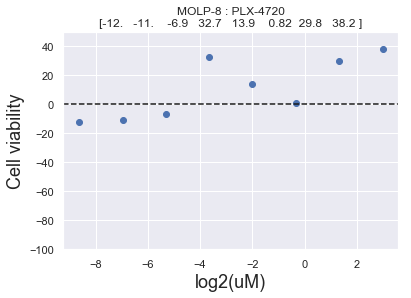

9480
9481
9482
9483
9484
9485
9486
9487
9488
NCI-H1184 PLX-4720


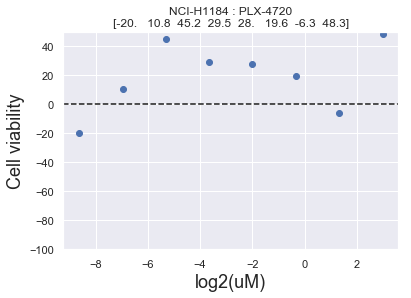

9489


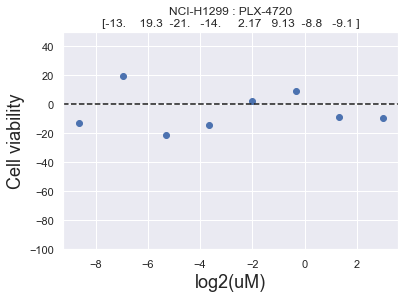

9490
9491
9492
9493
9494
9495
9496
NCI-H1573 PLX-4720


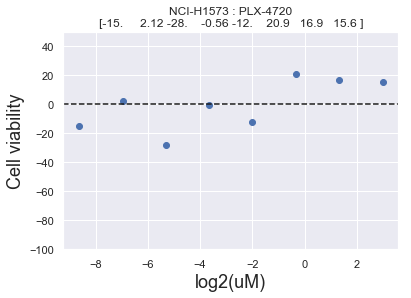

9497


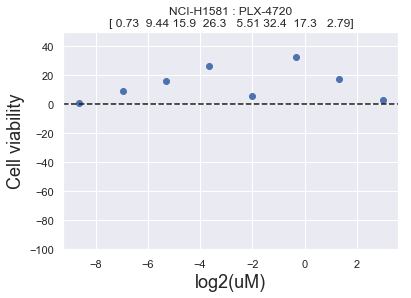

9498
9499
9500
9501
9502
9503
9504
9505
9506
9507
9508
9509
9510


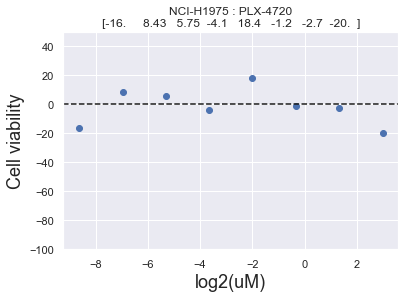

9511
9512
9513
9514
9515
9516
9517
9518
9519
9520
NCI-H2172 PLX-4720


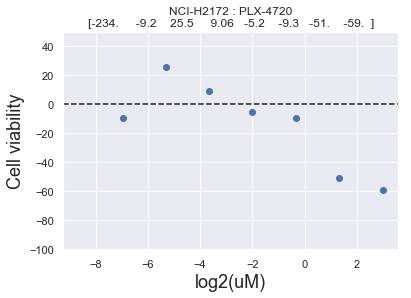

9521
9522
9523
9524
9525
9526
9527
9528
9529
9530
9531
9532
9533
9534
9535
9536
9537
9538
9539
9540
9541
9542
9543
9544
9545
9546
9547
9548
9549
9550
9551
9552
9553
9554
9555
9556
9557
OPM-2 PLX-4720


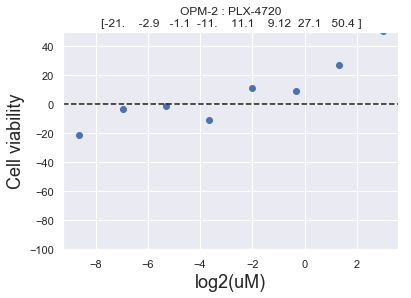

9558
9559
9560
9561
9562
9563
9564
9565
9566
9567
9568
9569
9570
9571
9572
9573
9574
9575
9576
9577
9578
9579
9580
QGP-1 PLX-4720


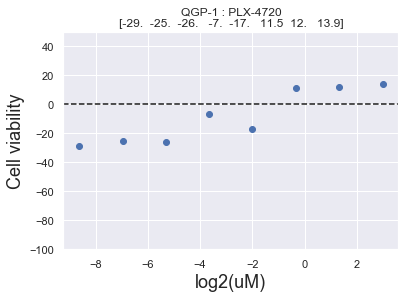

9581
Raji PLX-4720


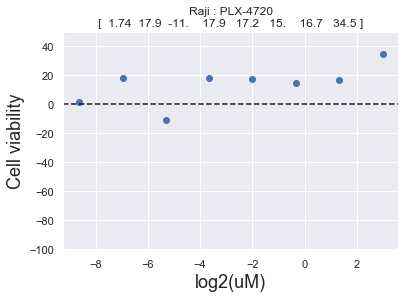

9582
9583
9584
9585
9586
9587
9588
9589
9590
9591
9592
9593
9594
9595
9596
9597
9598
9599
9600
9601
9602
9603
9604
9605
9606
9607
9608
9609
9610
9611
9612
9613
9614
9615
SK-MEL-2 PLX-4720


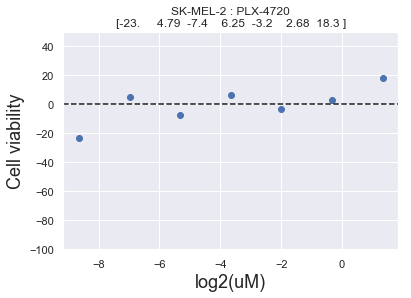

9616
9617
9618
9619
9620
9621
9622
9623
SKN PLX-4720


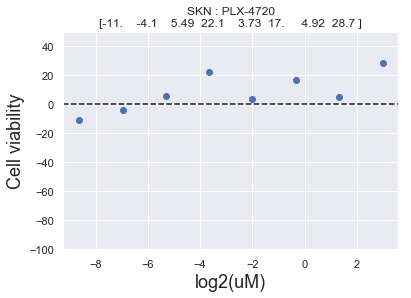

9624
9625


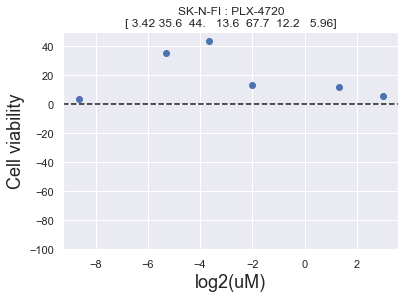

9626
9627
9628
9629
9630
9631
9632
9633
9634
9635
9636
9637
9638
9639
9640
9641
9642
9643
9644
9645
9646
9647
9648
9649
9650
9651
9652
9653
9654
9655
9656
9657
9658
SW620 PLX-4720


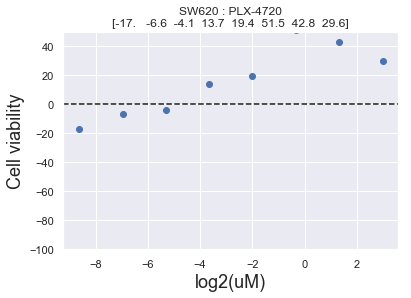

9659


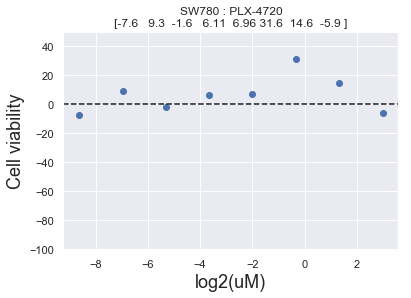

9660
9661
9662
9663
9664
9665
9666
9667
9668
9669
9670
9671
9672
9673
9674
9675
9676
9677
9678
9679
9680
9681
9682
9683
9684
9685
9686
9687
VMRC-LCD PLX-4720


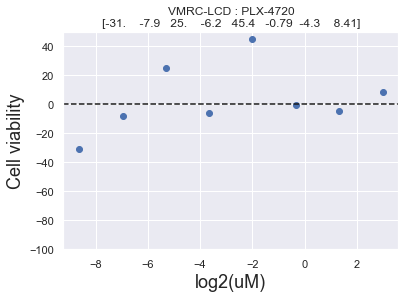

9688
9689
9690
9691
9692
9693
9694
9695
9696
9697
ZR751 PLX-4720


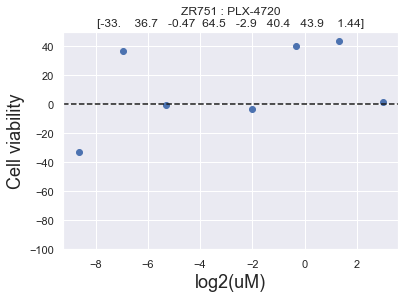

9698
9699
9700
9701
9702
9703
9704
9705
9706
9707
9708
9709
9710
9711
9712
9713
9714
9715
9716
9717
9718
9719
9720
9721
9722
9723
9724
9725
9726
9727
9728
9729
9730
9731
9732
9733
9734
9735
9736
9737
9738
9739
9740
9741
9742
9743
9744
9745
9746
9747
9748
9749
9750
9751
9752
9753
9754
9755
9756
9757
9758
9759
9760
9761
9762
9763
9764
9765
9766
9767
9768
9769
9770
9771
9772
9773
9774
9775
9776
9777
9778
9779
9780
9781
9782
9783
9784
9785
9786
9787
9788
9789
9790
9791
9792
9793
9794
9795
9796
9797
9798
9799
9800
9801
9802
9803
9804
9805
9806
9807
9808
9809
9810
9811
9812
9813
9814
9815
9816
9817
9818
9819
9820
9821
9822
9823
9824
9825
9826
9827
9828
9829
9830
9831
9832
9833
9834
9835
9836
9837
9838
9839
9840
9841
9842
9843
9844
9845
9846
9847
9848
9849
9850
9851
9852
9853
9854
9855
9856
9857
9858
9859
9860
9861
9862
9863
9864
9865
9866
9867
9868
9869
9870
9871
9872
9873
9874
9875
9876
9877
9878
9879
9880
9881
9882
9883
9884
9885
9886
9887
9888
9889
9890
9891
9892
9893
9894
9895
9896
9897


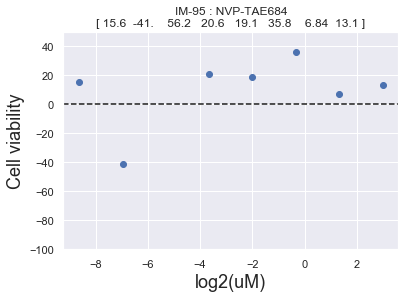

10333
10334
10335
10336
10337
10338
10339
10340
10341
10342
10343
10344
10345
10346
10347
JM1 NVP-TAE684


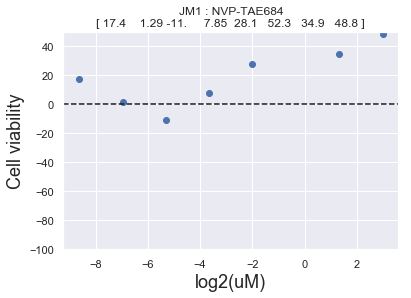

10348
10349
10350
10351
10352
10353
10354
10355
10356
10357
10358
10359
10360
10361
10362
10363
10364
10365
10366
10367
10368
10369
10370
10371
10372
10373
10374
10375
10376
10377
10378
10379
10380
10381
10382
10383
10384
KU812 NVP-TAE684


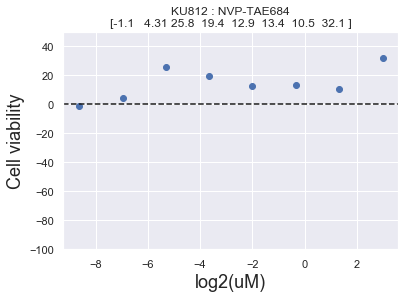

10385
10386
10387
10388
10389
10390
10391
10392
10393
10394
10395
10396
10397
10398
10399
10400
10401
10402
10403
10404
10405
10406
10407
10408
10409
10410
10411
10412
10413
10414
10415
10416
10417
10418
10419
10420
10421
10422
10423
10424
10425
10426
10427
10428
10429
10430
10431
10432
10433
10434
10435
10436
10437
10438
10439
10440
10441
10442
10443
10444
10445
10446
10447
10448
10449
10450
10451
10452
10453
10454
10455
10456
10457
10458
10459
10460
10461
10462
10463
10464
10465
10466
10467
10468
10469
10470
10471
10472
10473
10474
10475
10476
10477
10478
10479
10480
10481
10482
10483
10484
10485
10486
10487
10488
10489
10490
10491
10492
10493
10494
10495
10496
10497


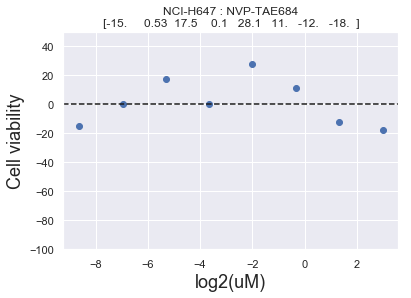

10498
10499
10500
10501
10502
10503
10504
10505
10506
10507
10508
10509
10510
10511
10512
10513
OCILY10 NVP-TAE684


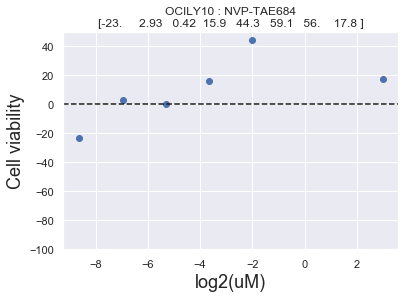

10514
10515
10516
10517
10518
10519
10520
10521
10522
10523
10524
10525
10526
10527
10528
10529
10530
10531
10532
10533
10534
10535
10536
10537
10538
10539
10540
10541
10542
10543
10544
10545
10546
10547
10548
10549
10550
10551
10552
10553
10554
10555
10556
10557
10558
10559
10560
10561
10562
10563
10564
10565
10566
10567
10568
10569
10570
10571
10572
10573
10574
10575
10576
10577
10578
10579
10580
10581
10582
10583
10584
10585
10586
10587
10588
10589
10590
10591
10592
10593
10594
10595
10596
10597
10598
10599
10600
10601
10602
10603
10604
10605
10606
10607
10608
10609
10610
10611
10612
10613
10614
10615
10616
10617
10618
10619
10620
10621
10622
10623
10624
10625
10626
10627
10628
10629
10630
10631
10632
10633
10634
10635
10636
10637
10638
10639
10640
10641
10642
10643
10644
10645
10646
10647
10648
10649
10650
10651
10652
10653
10654
10655
10656
10657
10658
10659
10660
10661
10662


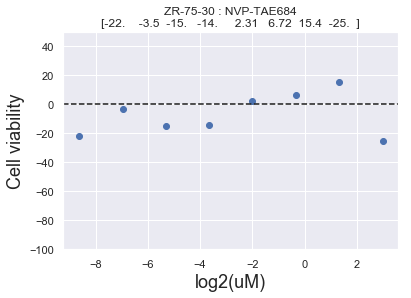

10663
10664
10665
10666
10667
10668
10669
10670
10671
10672
10673
10674
10675
10676
10677
10678
10679
10680
10681
10682
10683
10684
10685
10686
10687
10688
10689
10690
10691
10692
10693
10694
10695


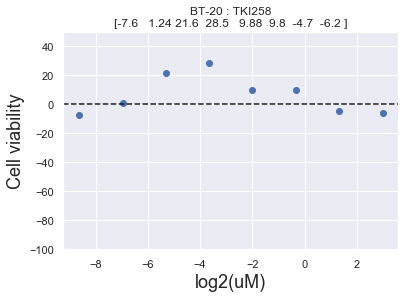

10696
10697
10698
10699
10700


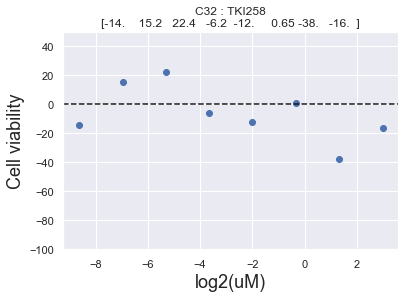

10701
10702
10703
10704
10705
10706
10707
10708
10709
10710
10711
10712
10713
10714
10715
10716
10717
10718
10719
10720
10721
10722
10723
10724
10725
10726
10727
10728
10729
10730
10731
10732
10733
10734
10735
10736
10737
10738
10739
10740
10741
10742
10743
10744
10745
10746
10747
10748
10749
10750
10751
10752
10753
10754
10755
10756
10757
10758
10759
10760
10761
10762
10763
10764
10765
10766
10767
10768
10769
10770
10771
10772
10773
10774
10775
10776
10777
10778
10779
10780
10781
10782
10783
10784
10785
10786
10787


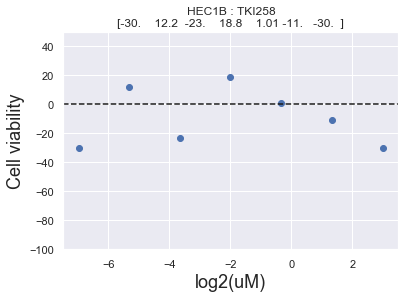

10788
10789
10790
10791
10792
10793
10794
10795
10796
10797
10798
10799
10800
10801
10802
10803
10804
10805
10806
10807
10808
10809
10810
10811
10812
10813
10814
10815
10816
10817
10818
10819
10820
10821
10822
10823
10824
10825
10826
10827
10828
10829
10830
10831
10832
10833
10834
10835
10836
10837
10838
10839
10840
10841
10842
10843
10844
10845
10846
10847
10848
10849
10850
10851
10852
10853
10854
10855
10856
10857
10858
10859
10860
10861
10862
10863
10864
10865
10866
10867
10868
10869
10870
10871
10872
10873
10874
10875
10876
10877
10878
10879
10880
10881
10882
10883
10884
10885
10886
10887
10888
10889
10890
10891
10892
10893
10894
10895
10896
10897
10898
10899
10900
10901
10902
10903
10904
10905
10906
10907
10908
10909
10910
10911
10912
10913
10914
10915
10916
10917
10918
10919
10920
10921
10922
10923
10924
10925
10926
10927
10928
10929
10930
10931
10932
10933
10934
10935
10936
10937
10938
10939
10940


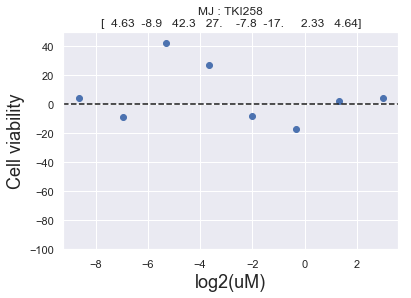

10941
10942
10943
10944
10945
10946
10947
10948
10949
10950
10951
10952
10953
10954
10955
10956
10957
10958
10959
10960
10961
10962
10963
10964
10965
10966
10967
10968
10969
10970
10971
10972
10973
10974
10975
10976
10977
10978
10979
10980
10981
10982
10983
10984
10985
10986
10987
10988
10989
10990
10991
10992
10993
10994
10995
10996
10997
10998
10999
11000
11001
11002
11003
11004
11005
11006
11007
11008
11009
11010
11011
11012
11013
11014
11015
11016
11017
11018
11019
11020
11021
11022
11023
11024
11025
11026
11027
11028
11029
11030
11031
11032
11033
11034
11035
11036
11037
11038
11039
11040
11041
11042
11043
11044
11045
11046
11047
11048
11049
11050
11051
11052
11053
11054
11055
11056
11057
11058
11059
11060
11061
11062
11063
11064
11065
11066
11067
11068
11069
11070
11071
11072
11073
11074
11075
11076
11077
11078
11079
11080
11081
11082
11083
11084
11085
11086
11087
11088
11089
11090
11091
11092
11093
11094
11095
11096
11097
11098
11099
11100
11101
11102
11103
11104


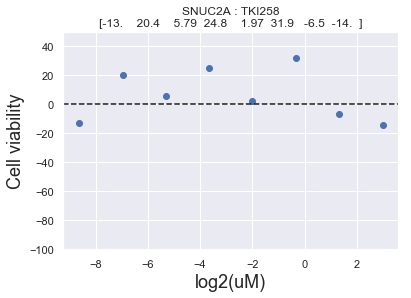

11105
11106
11107
11108
11109
11110
11111
11112
11113
11114
11115
11116
11117
11118
11119
11120
11121
11122
11123
11124
11125
11126
11127
11128
11129
11130
11131
11132
11133
11134
11135
11136
11137
11138
11139
11140
11141
11142
11143
11144
11145
11146
11147
11148
11149
11150
11151
11152
11153
11154
11155
11156
11157
11158
11159
11160
11161
11162
11163
11164
11165
11166
11167
11168
11169
11170
11171
11172
11173
11174
11175
11176
11177
11178
11179
11180
11181
11182
11183
11184
11185
11186
11187
11188
11189
11190
11191
11192
11193
11194
11195
11196
11197
11198
11199
11200
11201
11202
11203
11204
11205
11206
11207
11208
11209
11210
11211
11212
11213
11214
11215
11216
11217
11218
11219
11220
11221
11222
11223
11224
11225
11226
11227
11228
11229
11230
11231
11232
11233
11234
11235
11236
11237
11238
11239
11240
11241
11242
11243
11244
11245
11246
11247
11248
11249
11250
11251
11252
11253
11254
11255
11256
11257
11258
11259
11260
11261
11262
11263
11264
11265
11266
11267
11268
11269
11270
1127

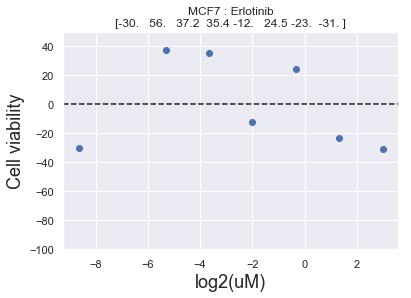

11425
11426
11427
11428
11429
11430
11431
11432
11433
11434
11435
11436
11437
11438
11439
11440
11441
11442
11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
SK-MEL-2 Erlotinib


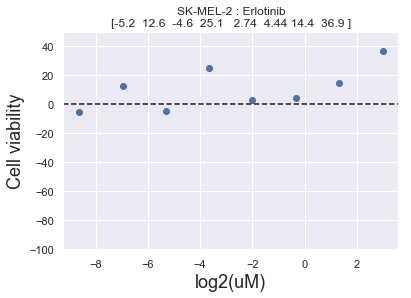

11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
11623
11624
11625
11626
11627
11628
11629
11630
11631
11632
11633
11634
11635
11636
TC-71 Erlotinib


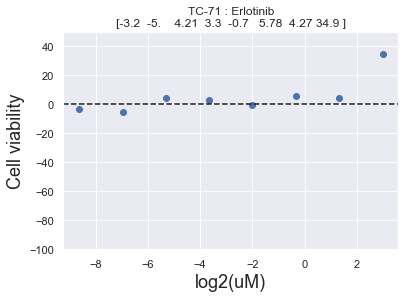

11637
11638
11639
11640
11641
11642
11643
11644
11645
11646
11647
11648
11649
11650
11651
11652
11653
11654
11655
11656
11657
11658
11659
11660
11661
11662
11663
11664
11665
11666
11667
11668
11669


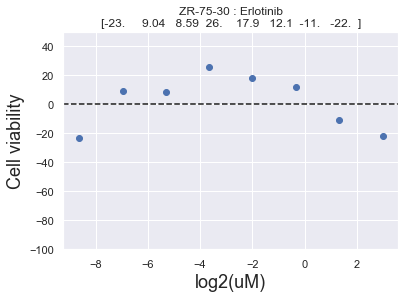

In [27]:
#for i in range(len(dataset_names)):
for i, row in dataset_names.iterrows():
    print(i)
    clname=row[sample_col_name]
    drname=row[drug_col_name]
    
    df=dataset[ (dataset[sample_col_name]==clname) & (dataset[drug_col_name]==drname) ]
    df=df.sort_values(dosage_col_name) #dosage not in increasing order in GDSC1
    
    sample=np.array(df[response_col_name])#t.values[i,:]
    log2dosage=np.log2(df[dosage_col_name])
    sample_sorted=sorted(list(sample))
    
    m=sample[round(len(sample)/2)]
    diff=sample[-1]-sample[0]
    ht_normalized=max(sample)-min(sample)
    ht=max(sample)-sample[0]
    ht2=sample_sorted[-2]-sample[0]
    
    
    category_df.at[clname,drname]=1#category_matrix[cl_set.index(names.values[i,0]),dr_set.index(names.values[i,1])]=1
    
    drug_id=dr_set.index(drname)#dr_set.index(names.values[i,1])
    cl_id=cl_set.index(clname)#cl_set.index(names.values[i,0])
    
      
    dr_freq=len(dataset_names[ dataset_names[drug_col_name]== drname])
    cl_freq=len(dataset_names[ dataset_names[sample_col_name]== clname] )
    
    drug_map.set_value( drug_id ,'#cl_tested', dr_freq)
    cl_map.set_value( cl_id ,'#dr_tested', cl_freq)
    
    
    if(abs(diff)<5 and ht>0.15*response_range and ht2>0.1*response_range):#5*diff):
        flag_3[i]=1
        category_df.at[clname,drname]=3 #category_matrix[cl_id,drug_id]=3
        plot_pair(clname,drname, sample,log2dosage,  "Hump", dataname)#
        
         
        #drug_map.set_value( drug_id ,'OUTLIER_COUNT', 1+drug_map.values[drug_id,1])
        #cl_map.set_value( cl_id ,'OUTLIER_COUNT', 1+cl_map.values[cl_id,1])
        
        
    elif(diff>0.15*response_range):#(diff>0.2*ht):
        print(clname,drname)
        flag_4[i]=1
        category_df.at[clname,drname]=4 #category_matrix[cl_id,drug_id]=4
        plot_pair(clname,drname, sample,log2dosage,  "Rising", dataname)#plot_pair(dataset_names, response, logDosage, i, "Rising", dataname)
        
        #drug_map.set_value( drug_id ,'OUTLIER_COUNT', 1+drug_map.values[drug_id,1])
        #cl_map.set_value( cl_id ,'OUTLIER_COUNT', 1+cl_map.values[cl_id,1])
      
    
    elif(m-sample[0] <-0.025*response_range and sample[-1]-m<-0.025*response_range):
        flag_2[i]=1
        #category_df.at[clname,drname]=2 ##category_matrix[cl_id,drug_id]=2 
        #plot_pair(clname,drname, sample,log2dosage,  "S", dataname)#plot_pair(dataset_names, response, logDosage, i, "S", dataname)
    else:
        flag_1[i]=1
        #category_df.at[clname,drname]=1 ##category_matrix[cl_id,drug_id]=1
        #plot_pair(clname,drname, sample,log2dosage,  "Constant", dataname)#plot_pair(dataset_names, response, logDosage, i, "Constant", dataname)
    

In [42]:
#drug_map= pd.read_csv("../data_processed/CurveCategoryDetection/"+dataname+"_OutliersPerDrug.tsv", sep='\t')
#cl_map=   pd.read_csv("./data_processed/CurveCategoryDetection/"+dataname+"_OutliersPerCellLine.tsv", sep='\t')

drug_map=pd.DataFrame( drug_map.sort_values('OUTLIER_COUNT',ascending=False) )
cl_map=pd.DataFrame( cl_map.sort_values('OUTLIER_COUNT',ascending=False) )

drug_map[['%']] = (100*drug_map[['OUTLIER_COUNT']].div(drug_map['#cl_tested'].values,axis=0)).round(2)
cl_map[['%']] = (100*cl_map[['OUTLIER_COUNT']].div(cl_map['#dr_tested'].values,axis=0)).round(2)

drug_map.to_csv("../data_processed/CurveCategoryDetection/"+dataname+"_OutliersPerDrug.tsv", sep='\t', index=False)
cl_map.to_csv("../data_processed/CurveCategoryDetection/"+dataname+"_OutliersPerCellLine.tsv", sep='\t', index=False)

In [43]:
category_df.to_csv("../data_processed/CurveCategoryDetection/"+dataname+"_CurveCategory.tsv", sep='\t')
# 0:not tested, 1:tested, 3:H, 4;R

In [44]:
n=len(dataset_names)
print("No of cell line drug pairs="+str(n))
print("No. (percentage) of hump shaped pairs: "+str(np.count_nonzero(flag_3) )+" ("+str(round(np.count_nonzero(flag_3)/n*100 , 3) )+"%)")
print("No. (percentage) of rising shaped pairs: "+str(np.count_nonzero(flag_4) ) +" ("+str(round(np.count_nonzero(flag_4)/n*100 , 3))+"%)")
print("TOTAL outliers (percentage): "+ str(np.count_nonzero(flag_3)+np.count_nonzero(flag_4) )+" ("+str(round(( np.count_nonzero(flag_3) + np.count_nonzero(flag_4)  )/n*100 , 3))+"%)")

print("\n No. (percentage) of DW pairs: "+str(np.count_nonzero(flag_2) )+" ("+str(round(np.count_nonzero(flag_2)/n*100 , 3) )+"%)")
print("\n No. (percentage) of DNW pairs: "+str(np.count_nonzero(flag_1) )+" ("+str(round(np.count_nonzero(flag_1)/n*100 , 3) )+"%)")


No of cell line drug pairs=11670
No. (percentage) of hump shaped pairs: 86 (0.737%)
No. (percentage) of rising shaped pairs: 155 (1.328%)
TOTAL outliers (percentage): 241 (2.065%)

 No. (percentage) of DW pairs: 4472 (38.32%)

 No. (percentage) of DNW pairs: 6957 (59.614%)
